In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('darkgrid')
matplotlib.rcParams.update({'font.size': 18})

import re
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.model_selection import train_test_split

from scipy import sparse as sp
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.spatial.distance import cosine

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression

C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]
        
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        y = y[::-1]
        x = x[::-1]
        good_idx = np.where(y >= prec_level)[0]
        
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
            
        else:
            pr_aucs.append(0)
            print(f"---------------   Вес: {counts[i]/len(categories):.5f}   {category}")
            weights.append(counts[i] / len(categories))
            
#             plt.plot(x,y)
#             plt.xlim((0,1))
#             plt.ylim((0,1))
#             plt.show()
            continue
            
        weights.append(counts[i] / len(categories))
    

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                fig, ax1 = plt.subplots(1, figsize=(15, 7))
#                 plt.figure(figsize=(20,20))
                ax1.axhline(y=0.75, color='grey', linestyle='-')
                plt.title(f"pr-auc: {pr_auc_prec_level:.5f}   Вес: {counts[i]/len(categories):.5f}   {category}")
                plt.plot(x,y)
                plt.xlim((0,1))
                plt.ylim((0,1))
                plt.show()
                print(f"pr-auc: {pr_auc_prec_level:.5f}   Вес: {counts[i]/len(categories):.5f}   {category}")
        except ValueError as err:
            pr_aucs.append(0)
#             weights.append(0)
            print(f"---------------   Вес: {counts[i]/len(categories):.5f}   {category}")
    return np.average(pr_aucs, weights=weights)

### Загрузка данных

In [3]:
train_data = pd.read_parquet('datasets/train_data.parquet')
train_data.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


In [4]:
pairs = pd.read_parquet('datasets/train_pairs.parquet')
pairs.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


### Предобработка данных

In [5]:
train_data['characteristic_attributes_mapping'].fillna('', inplace=True)

In [6]:
def clean_text(text):
    '''функция удалит все кроме английских букв, цифр, запятых(не окруженных пробелами), точек(не окруженных пробелами) и тире'''
    text = re.sub(r'[^a-zA-Z0-9.,-]', ' ', text) #тире убираем тоже, т.к. токенайзер разделяет слова по нему
#     text = re.sub(r'\b[a-zA-Z]+\b', '', text)
    text = re.sub(r'(?<=[a-zA-Z])\.(?=[a-zA-Z])', ' ', text)
    text = re.sub(r'\s\.\s', ' ', text)
    text = re.sub(r'\s\,\s', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.strip(' ')
    return text

In [7]:
def subcat_name(cat_dict):
    title = json.loads(cat_dict)['3']
    return title

In [8]:
def features_to_numpy(val):
    array_1 = np.array([x[0] for x in val.main_pic_embeddings_resnet_v1_x])
    array_2 = np.array([x[0] for x in val.main_pic_embeddings_resnet_v1_y])
    return array_1, array_2

In [9]:
train_data['cleaned'] = train_data['name'].apply(clean_text)
train_data['category'] = train_data['categories'].apply(subcat_name)
# train_data['brand'] = train_data['characteristic_attributes_mapping'].apply(brand_name)

In [10]:
print(train_data['cleaned'].str.contains('й').sum())
print(train_data['cleaned'].str.contains('ё').sum())

0
0


In [11]:
cat3_counts = train_data["category"].value_counts().to_dict()
cat3_counts

{'Смартфоны, планшеты, мобильные телефоны': 59389,
 'Компьютер': 57572,
 'Чехол': 40775,
 'Расходник для печати': 38878,
 'Кабели и переходники': 26669,
 'Наушники и гарнитуры': 16944,
 'Смарт-часы': 14811,
 'Устройство ручного ввода': 14235,
 'Батарейки и аккумуляторы': 12548,
 'Зарядные устройства и док-станции': 12014,
 'Запчасти для ноутбуков': 11791,
 'Запчасти для смартфонов': 10716,
 'Жесткие диски, SSD и сетевые накопители': 10221,
 'Материнская плата': 9895,
 'Видеонаблюдение': 9791,
 'Защитные пленки и стекла': 9225,
 'Оптические приборы': 5874,
 'Карты памяти и флешки': 5741,
 'Телевизоры': 5504,
 'Игровая приставка': 5300,
 'Акустика и колонки': 5287,
 'Электронные модули': 5144,
 'Сетевое оборудование': 5026,
 'Видеокарты и графические ускорители': 4578,
 'Мониторы и запчасти': 4361,
 'Оперативная память': 3877,
 'Сетевые фильтры, разветвители и удлинители': 3658,
 'Принтеры и МФУ': 3643,
 'Аксессуары для фото и видеотехники': 2905,
 'Кронштейн': 2650,
 'Видеорегистратор':

In [12]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1000:
        cntr += cat3_counts[cat3]
        
cntr

11296

In [13]:
train_data["cat3_grouped"] = train_data["category"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

### Merge тренировочного датасета

In [14]:
data = pairs.merge(train_data, left_on='variantid1', right_on='variantid', how='left') \
     .merge(train_data, left_on='variantid2', right_on='variantid', how='left')
data.head()

,target,variantid1,variantid2,variantid_x,name_x,categories_x,color_parsed_x,pic_embeddings_resnet_v1_x,main_pic_embeddings_resnet_v1_x,name_bert_64_x,...,name_y,categories_y,color_parsed_y,pic_embeddings_resnet_v1_y,main_pic_embeddings_resnet_v1_y,name_bert_64_y,characteristic_attributes_mapping_y,cleaned_y,category_y,cat3_grouped_y
0,0.0,51197862,51198054,51197862,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...",...,Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к...",TDM Electric 05 1.5 SQ1303-0136,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители"
1,1.0,53062686,536165289,53062686,Картридж лазерный Комус 729 (4370B002) черный ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]",None,"[[-0.0032773763, 0.32531193, -0.33156675, 0.41...","[-0.53706163, 0.37264067, 0.44363657, -0.37289...",...,Картридж лазерный Комус 729 (4368B002) пур. дл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[-0.043616347, 0.49310583, -0.3069673, 0.4820...","[-0.51572454, 0.40346462, 0.43528882, -0.34104...","{""Бренд"":[""Комус""],""Тип"":[""Картридж""]}",729 4368B002 CanonLBP7010C 7018,Расходник для печати,Расходник для печати
2,1.0,53602615,587809782,53602615,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...",...,Картридж лазерный Комус 729 (4370B002) чер. дл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]",None,"[[-0.041107245, 0.48485547, -0.2837791, 0.4637...","[-0.5087511, 0.46164495, 0.42914906, -0.462508...","{""Тип"":[""Картридж""],""Бренд"":[""Нет бренда""]}",729 4370B002 CanonLBP7010C 7018,Расходник для печати,Расходник для печати
3,1.0,53888651,89598677,53888651,Умные часы для детей S4,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...",[голубой],"[[0.680753, 0.09113727, 1.6140693, -0.04641545...","[[0.8777658, -0.42428812, 1.1310052, 0.4280405...","[-0.45303595, 0.35168907, 0.45074046, -0.29676...",...,"Умные часы для детей S4, зеленый","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...","[голубой, зеленый]","[[0.48835745, 0.1087057, 1.6226497, 0.13992776...","[[0.6647656, -0.07456402, 1.2397044, 0.6757724...","[-0.43019646, 0.3099462, 0.45133576, -0.297509...","{""Размеры, мм"":[""45х39х14""],""Название цвета"":[...","S4,",Смарт-часы,Смарт-часы
4,0.0,56930698,551526166,56930698,Аккумулятор для смартфона Xiaomi BN41 ( Redmi ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",[черный],None,"[[-0.2516712, -0.042763397, 0.29271233, 0.2847...","[-0.637286, 0.5249721, 0.6592931, -0.5001871, ...",...,Аккумулятор для телефона Xiaomi BN41 ( Redmi N...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",[черный],None,"[[-0.16422251, -0.089478336, 0.29960525, 0.246...","[-0.6326568, 0.5248482, 0.6736372, -0.5164456,...","{""Вес с упаковкой, г"":[""250""],""Список совмести...",Xiaomi BN41 Redmi Note 4 Note 4 Pro -,Батарейки и аккумуляторы,Батарейки и аккумуляторы


In [15]:
# data = data[data['cat3_grouped_x'] == 'Видеокарты и графические ускорители']

In [16]:
import lightgbm as ltb

C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


### Обучение и валидация модели

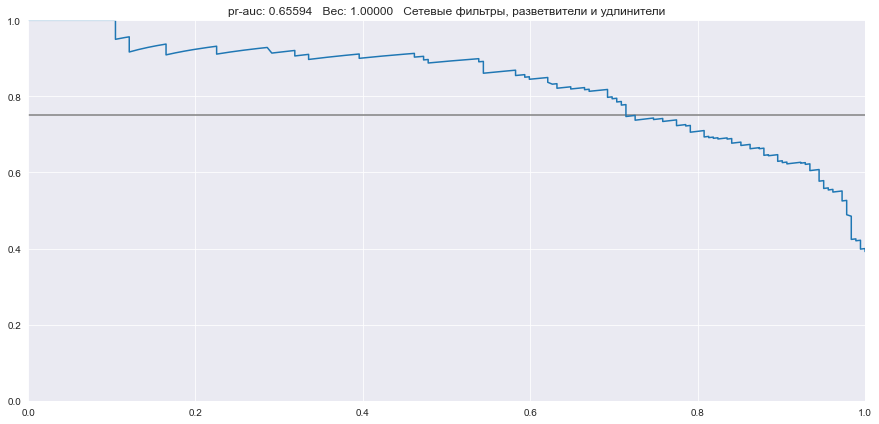

pr-auc: 0.65594   Вес: 1.00000   Сетевые фильтры, разветвители и удлинители


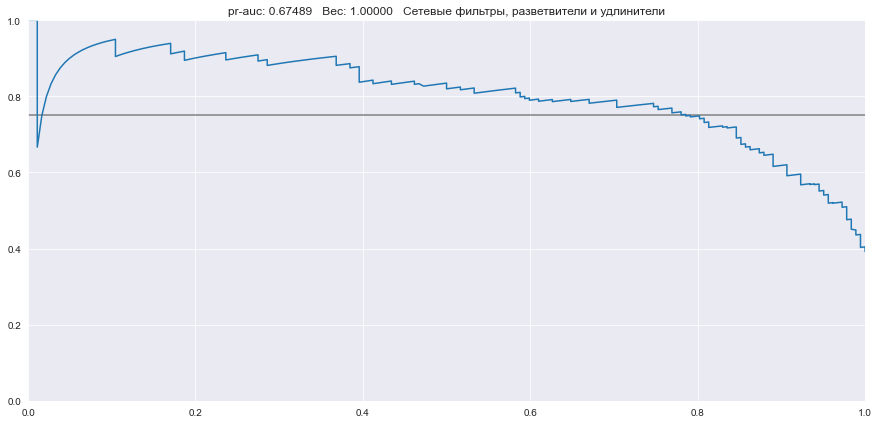

pr-auc: 0.67489   Вес: 1.00000   Сетевые фильтры, разветвители и удлинители



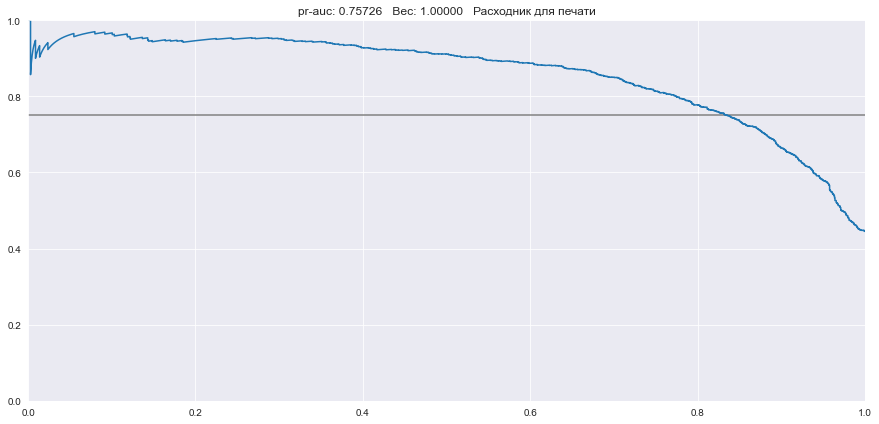

pr-auc: 0.75726   Вес: 1.00000   Расходник для печати


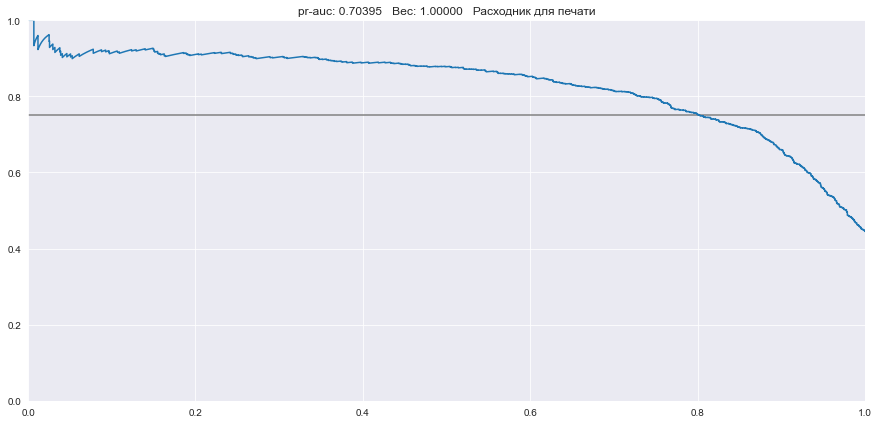

pr-auc: 0.70395   Вес: 1.00000   Расходник для печати



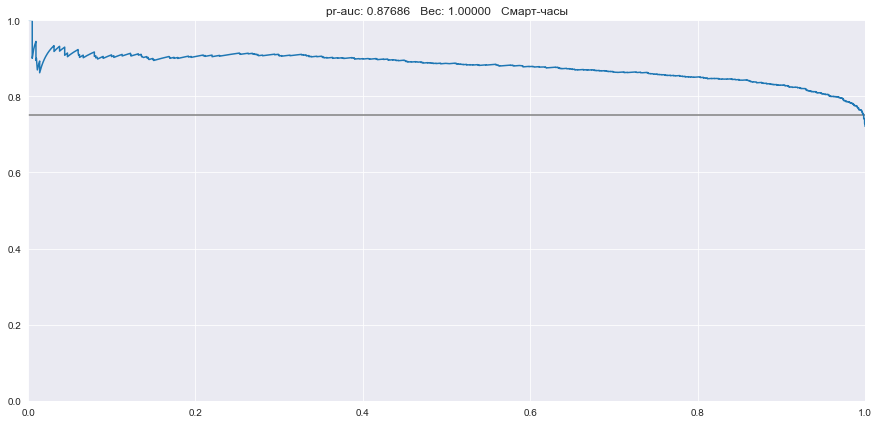

pr-auc: 0.87686   Вес: 1.00000   Смарт-часы


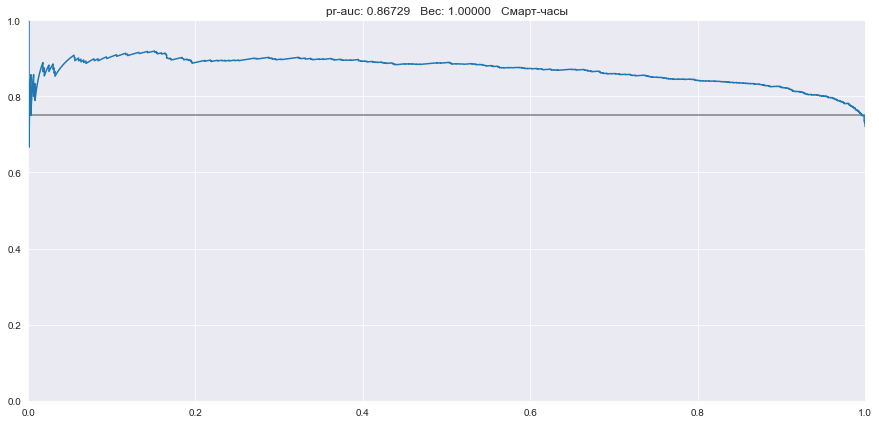

pr-auc: 0.86729   Вес: 1.00000   Смарт-часы



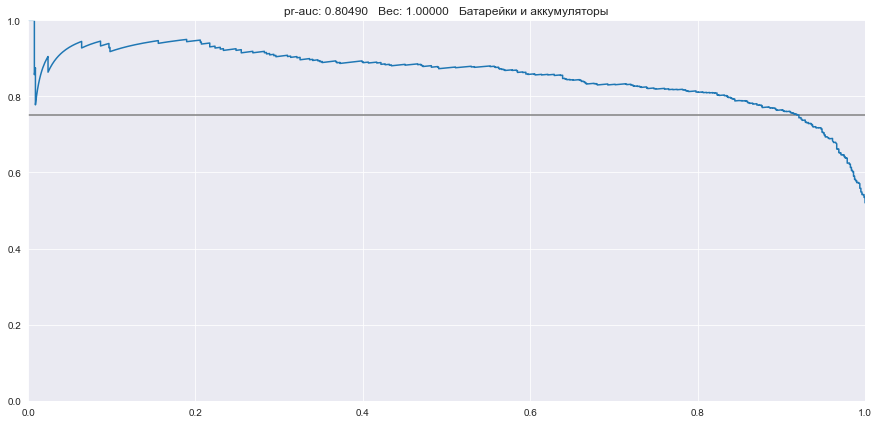

pr-auc: 0.80490   Вес: 1.00000   Батарейки и аккумуляторы


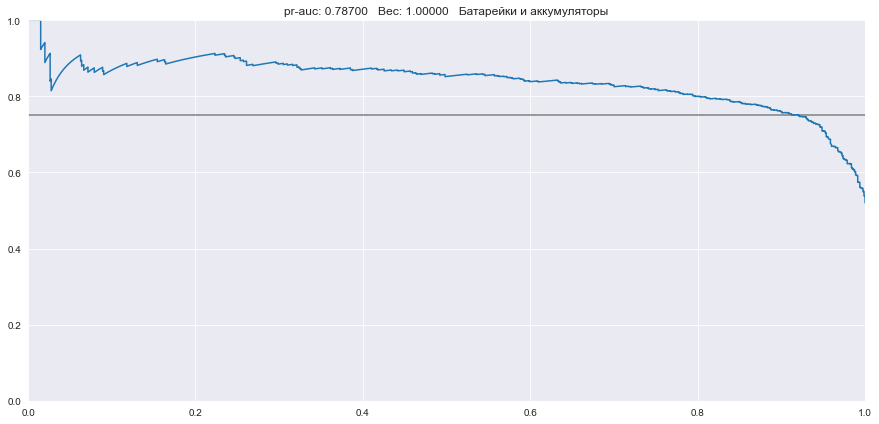

pr-auc: 0.78700   Вес: 1.00000   Батарейки и аккумуляторы



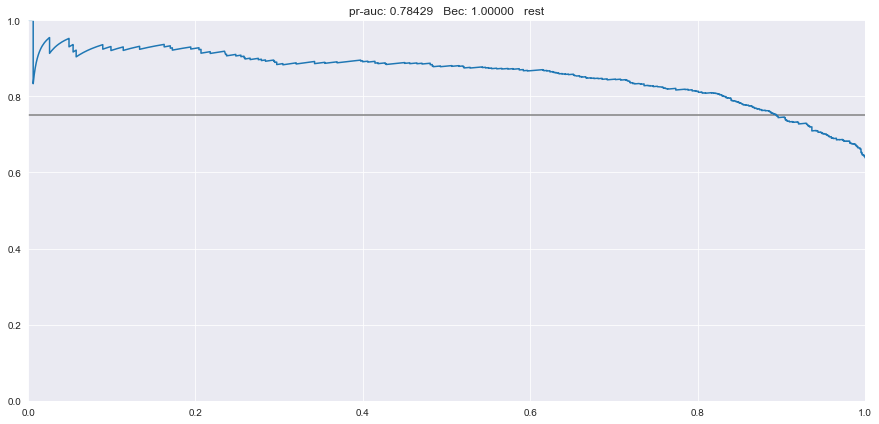

pr-auc: 0.78429   Вес: 1.00000   rest


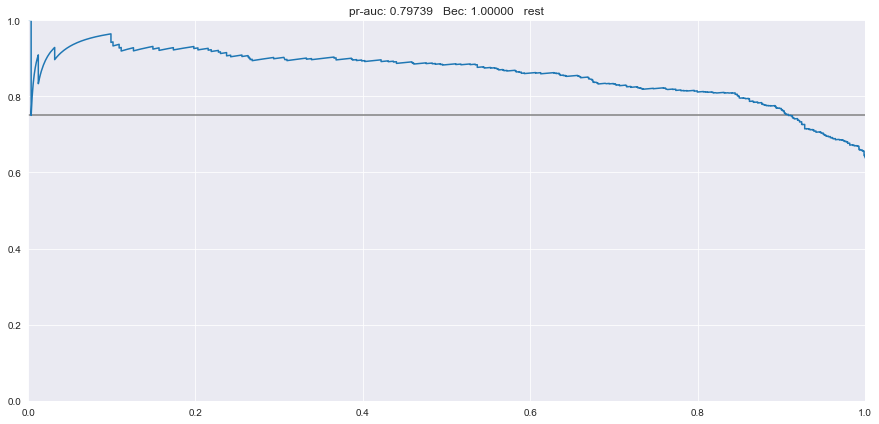

pr-auc: 0.79739   Вес: 1.00000   rest



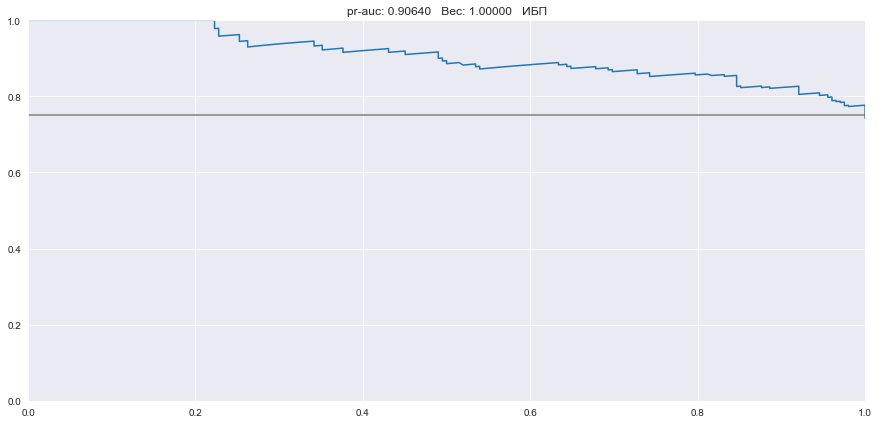

pr-auc: 0.90640   Вес: 1.00000   ИБП


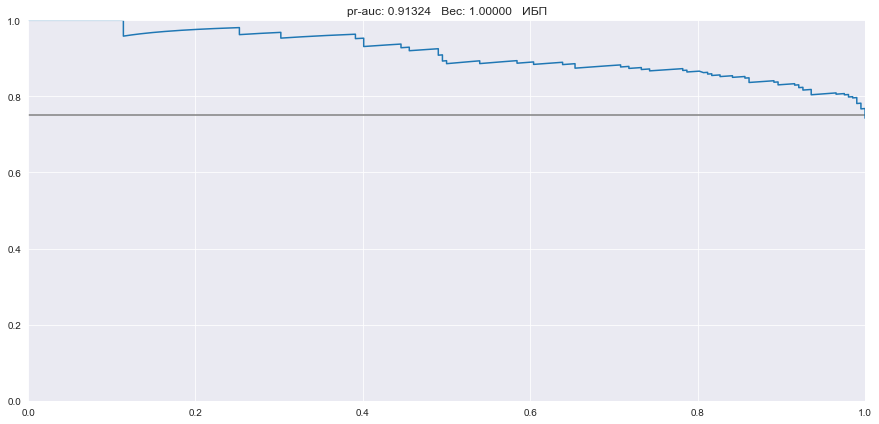

pr-auc: 0.91324   Вес: 1.00000   ИБП



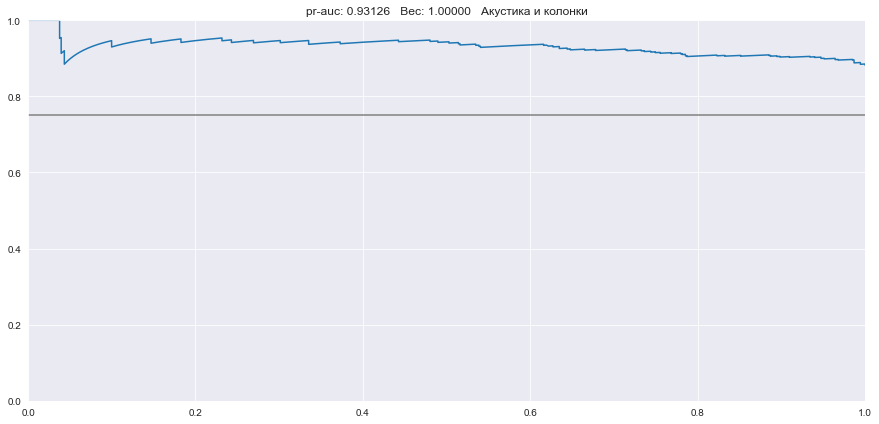

pr-auc: 0.93126   Вес: 1.00000   Акустика и колонки


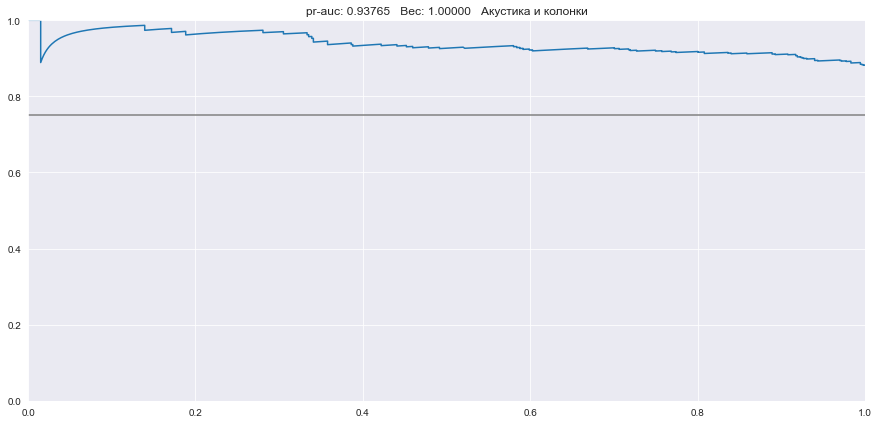

pr-auc: 0.93765   Вес: 1.00000   Акустика и колонки



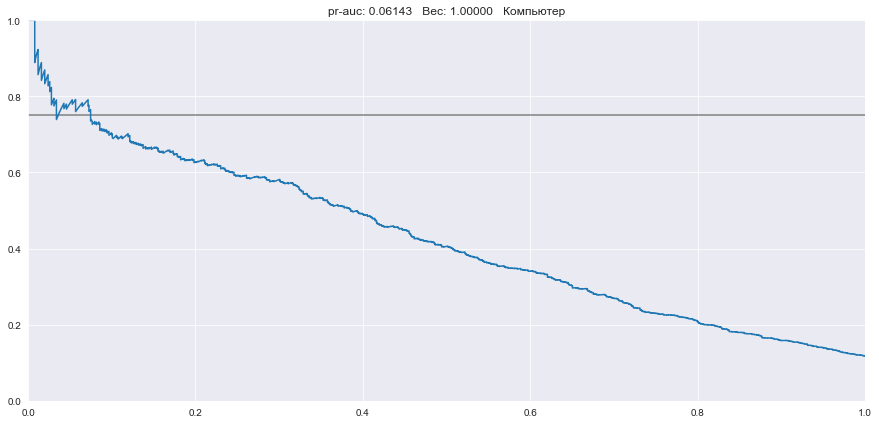

pr-auc: 0.06143   Вес: 1.00000   Компьютер


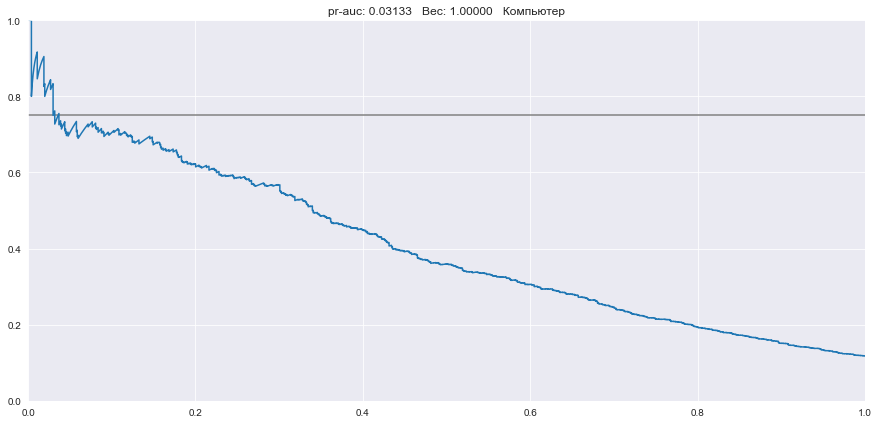

pr-auc: 0.03133   Вес: 1.00000   Компьютер



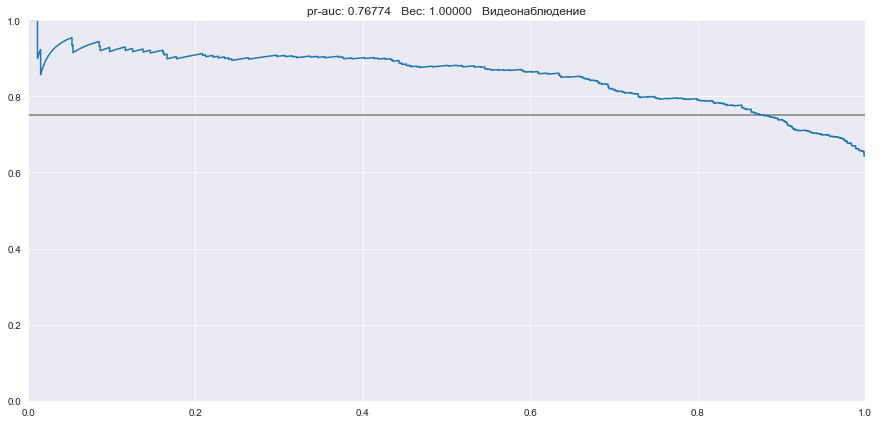

pr-auc: 0.76774   Вес: 1.00000   Видеонаблюдение


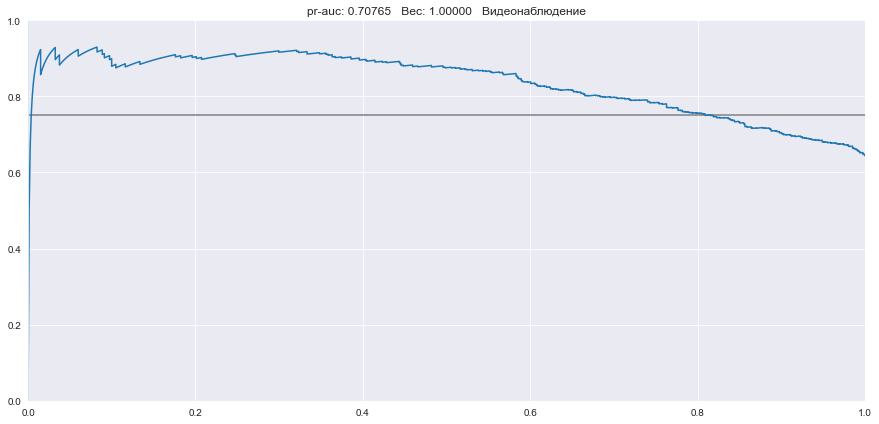

pr-auc: 0.70765   Вес: 1.00000   Видеонаблюдение



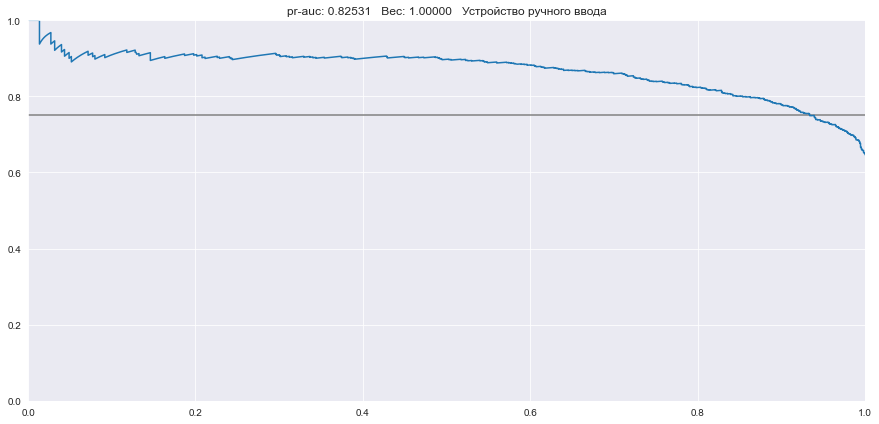

pr-auc: 0.82531   Вес: 1.00000   Устройство ручного ввода


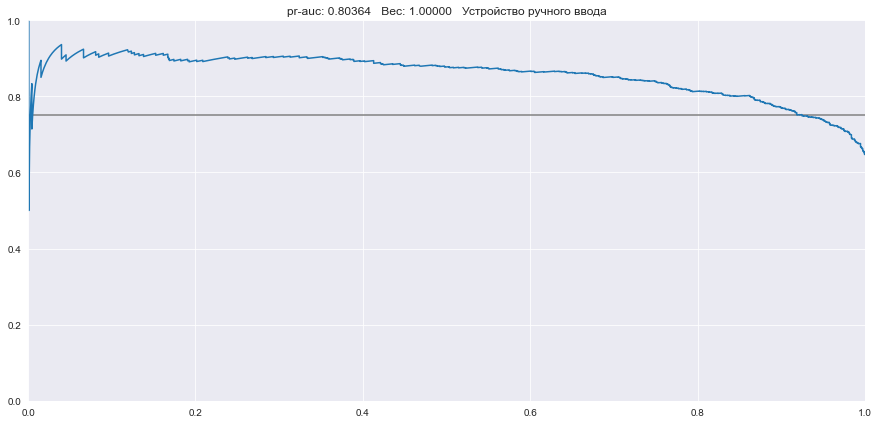

pr-auc: 0.80364   Вес: 1.00000   Устройство ручного ввода



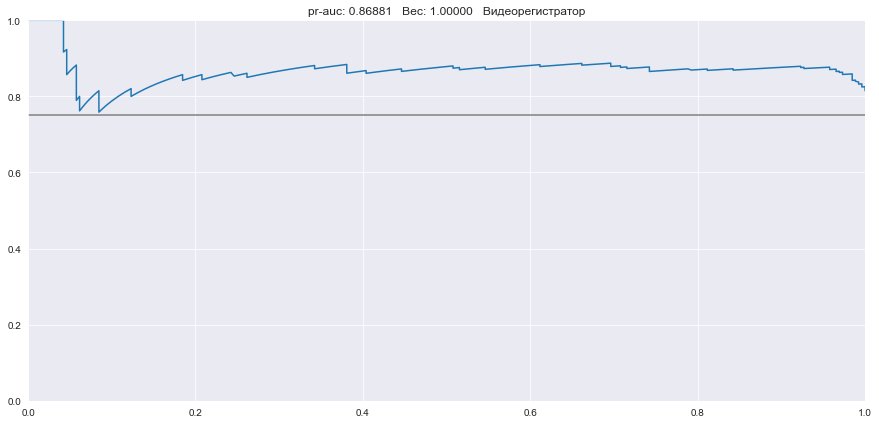

pr-auc: 0.86881   Вес: 1.00000   Видеорегистратор


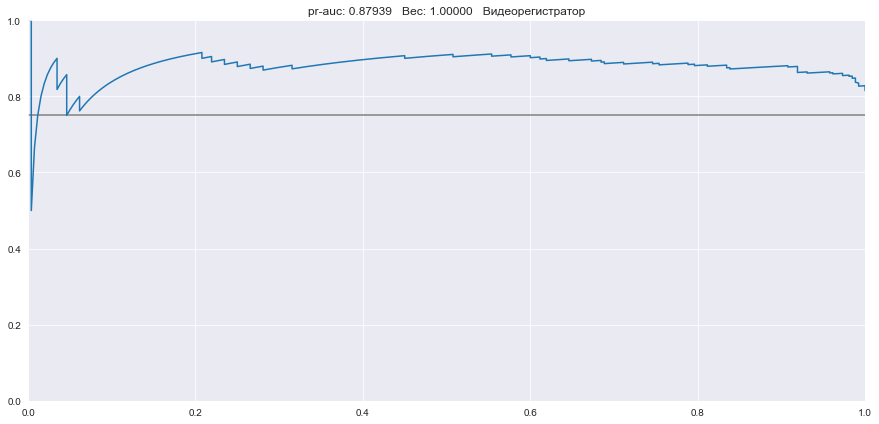

pr-auc: 0.87939   Вес: 1.00000   Видеорегистратор



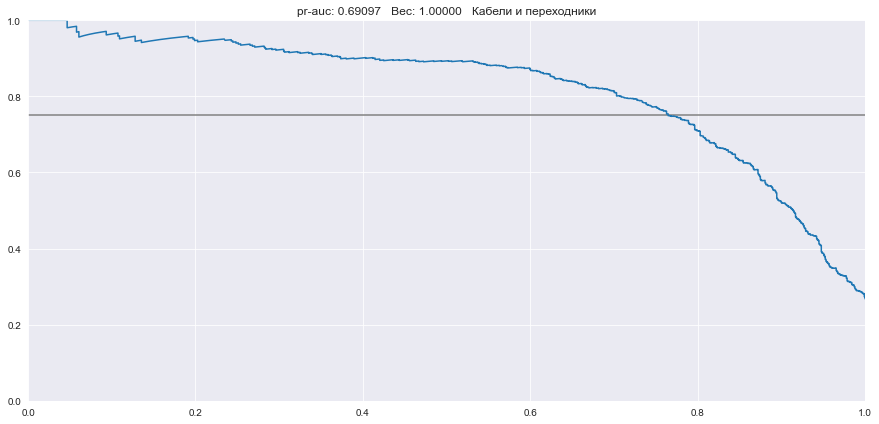

pr-auc: 0.69097   Вес: 1.00000   Кабели и переходники


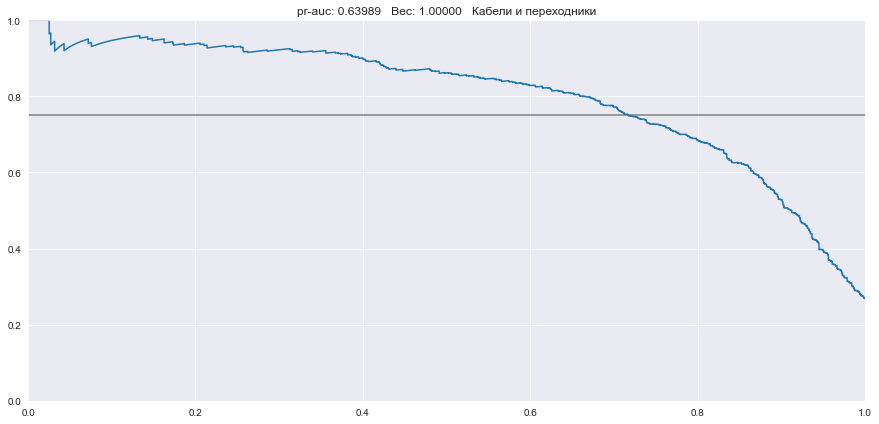

pr-auc: 0.63989   Вес: 1.00000   Кабели и переходники



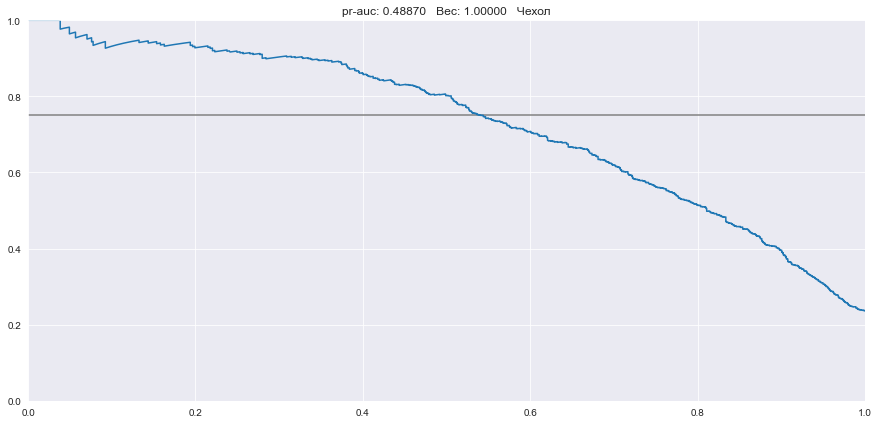

pr-auc: 0.48870   Вес: 1.00000   Чехол


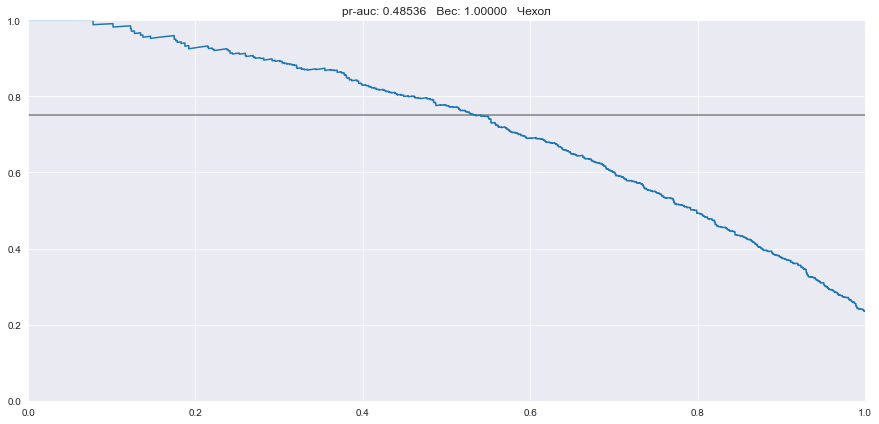

pr-auc: 0.48536   Вес: 1.00000   Чехол



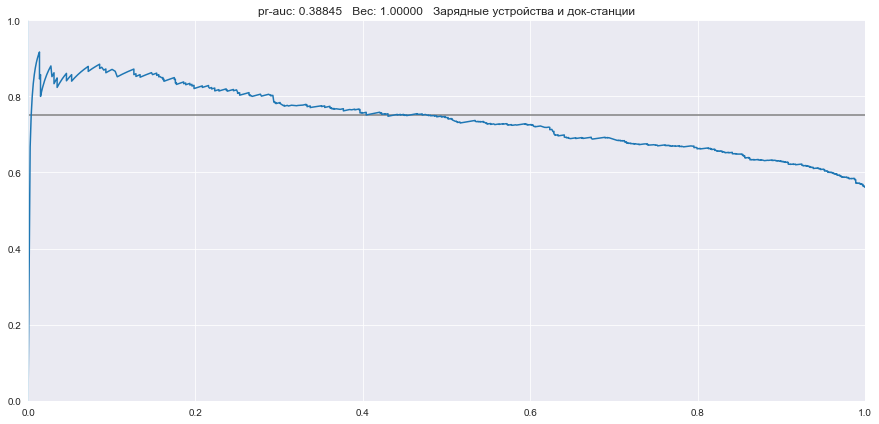

pr-auc: 0.38845   Вес: 1.00000   Зарядные устройства и док-станции


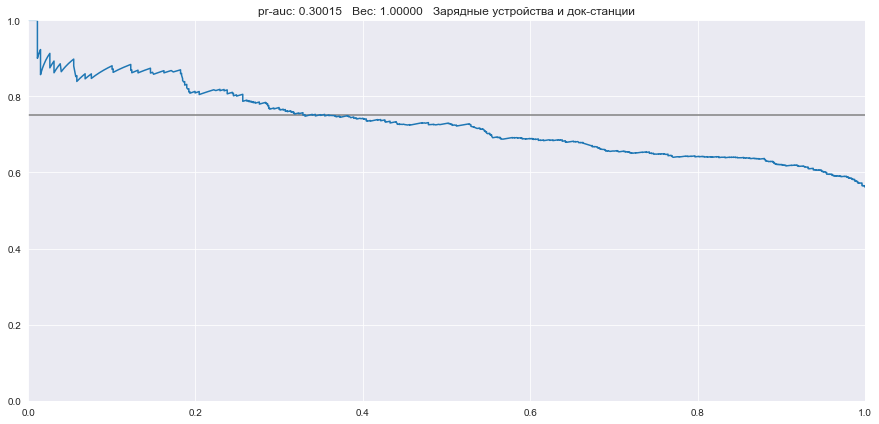

pr-auc: 0.30015   Вес: 1.00000   Зарядные устройства и док-станции



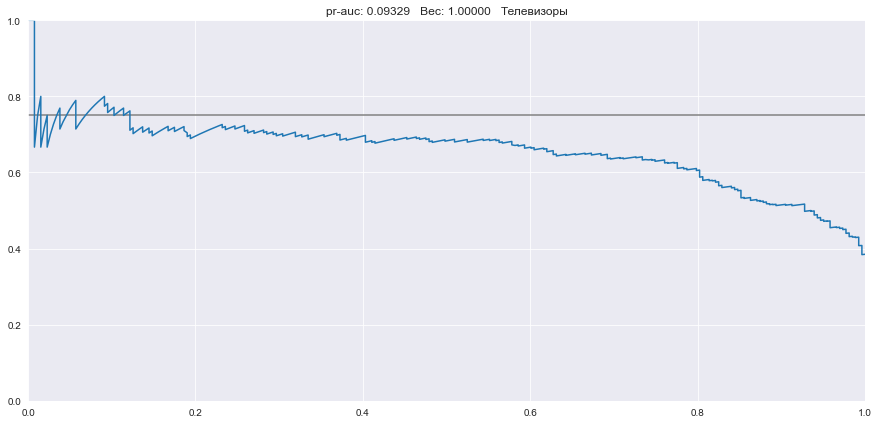

pr-auc: 0.09329   Вес: 1.00000   Телевизоры


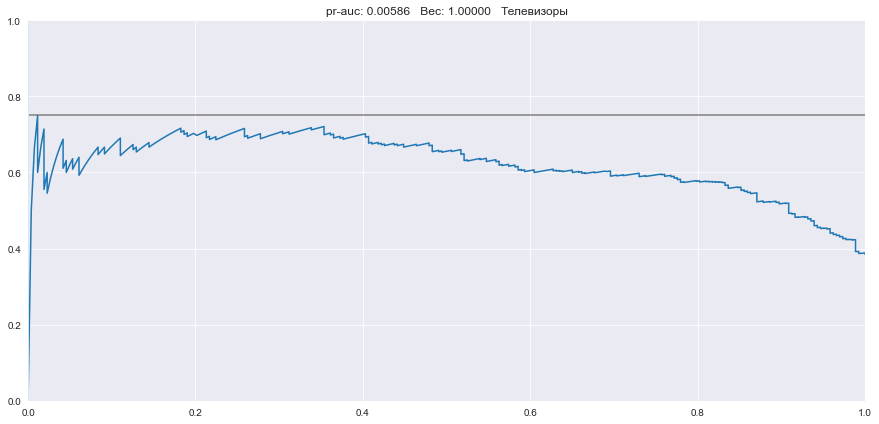

pr-auc: 0.00586   Вес: 1.00000   Телевизоры



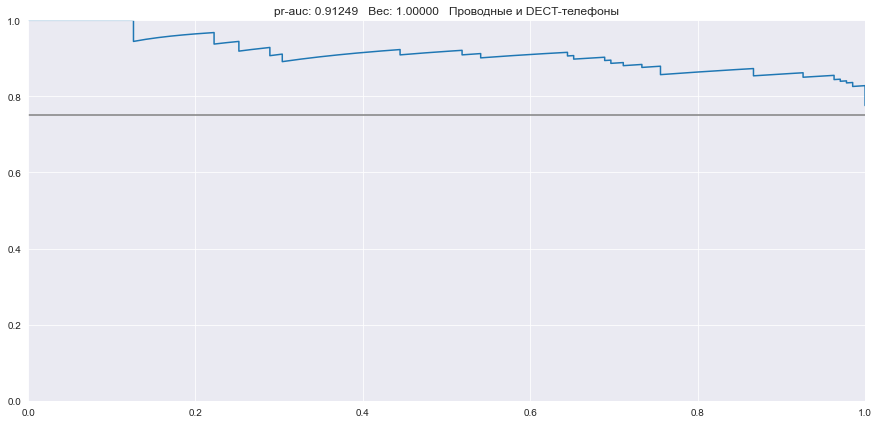

pr-auc: 0.91249   Вес: 1.00000   Проводные и DECT-телефоны


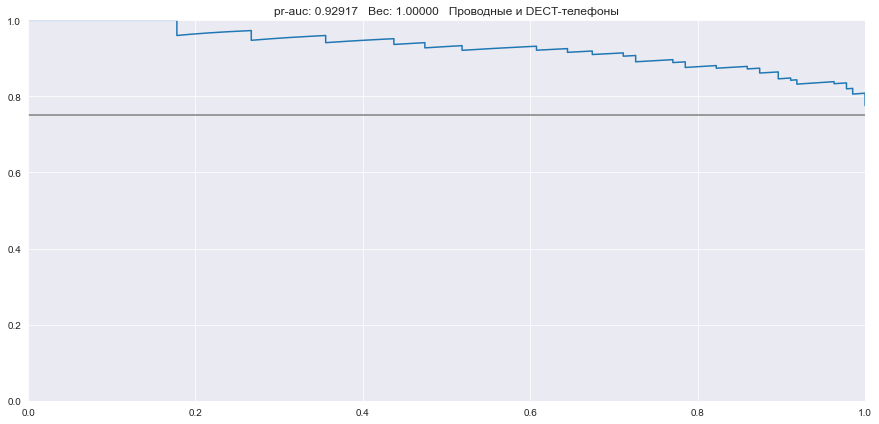

pr-auc: 0.92917   Вес: 1.00000   Проводные и DECT-телефоны



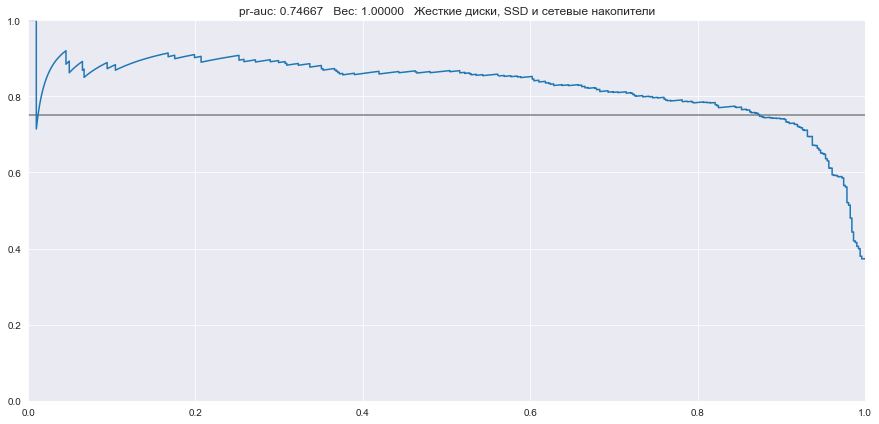

pr-auc: 0.74667   Вес: 1.00000   Жесткие диски, SSD и сетевые накопители


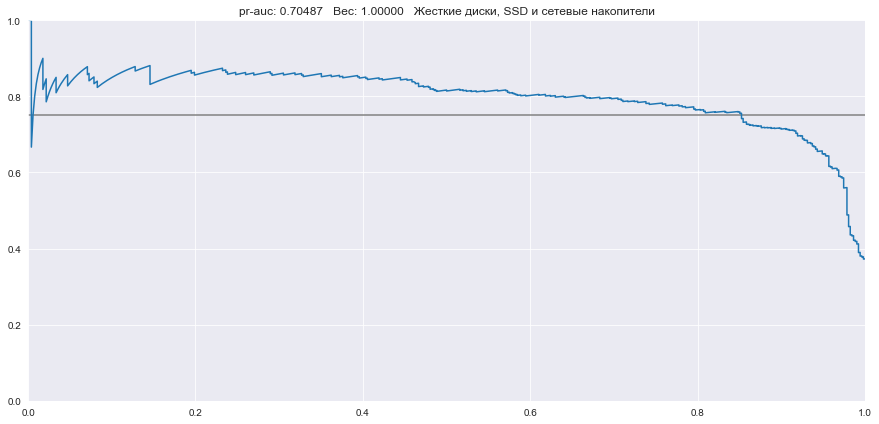

pr-auc: 0.70487   Вес: 1.00000   Жесткие диски, SSD и сетевые накопители



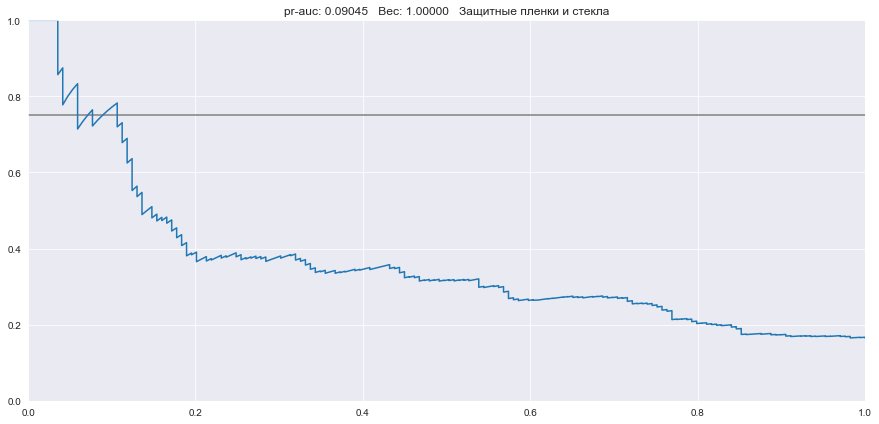

pr-auc: 0.09045   Вес: 1.00000   Защитные пленки и стекла


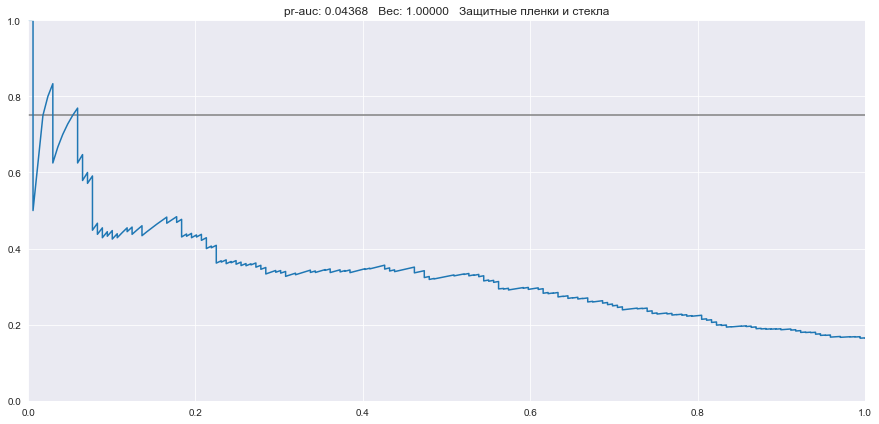

pr-auc: 0.04368   Вес: 1.00000   Защитные пленки и стекла



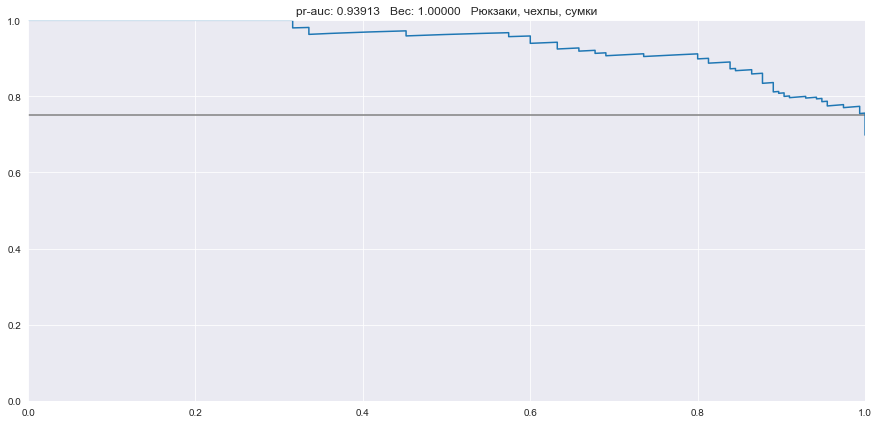

pr-auc: 0.93913   Вес: 1.00000   Рюкзаки, чехлы, сумки


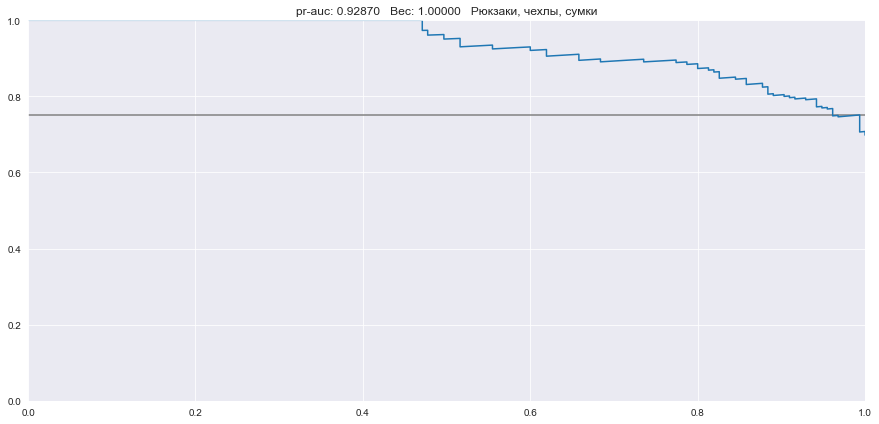

pr-auc: 0.92870   Вес: 1.00000   Рюкзаки, чехлы, сумки



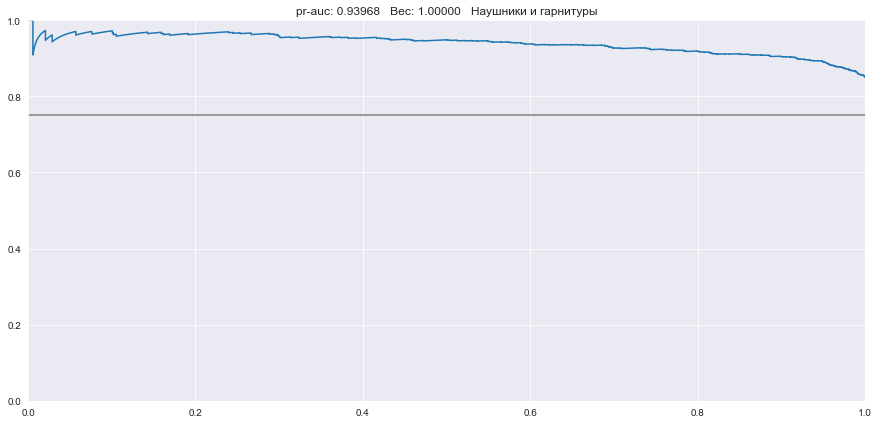

pr-auc: 0.93968   Вес: 1.00000   Наушники и гарнитуры


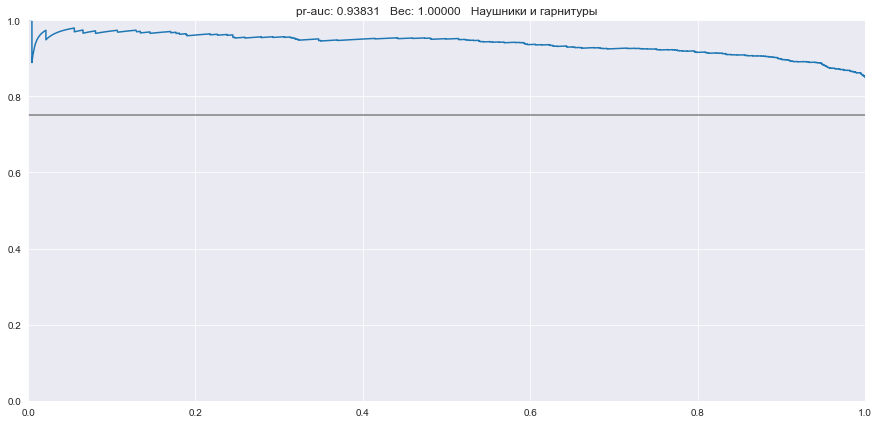

pr-auc: 0.93831   Вес: 1.00000   Наушники и гарнитуры



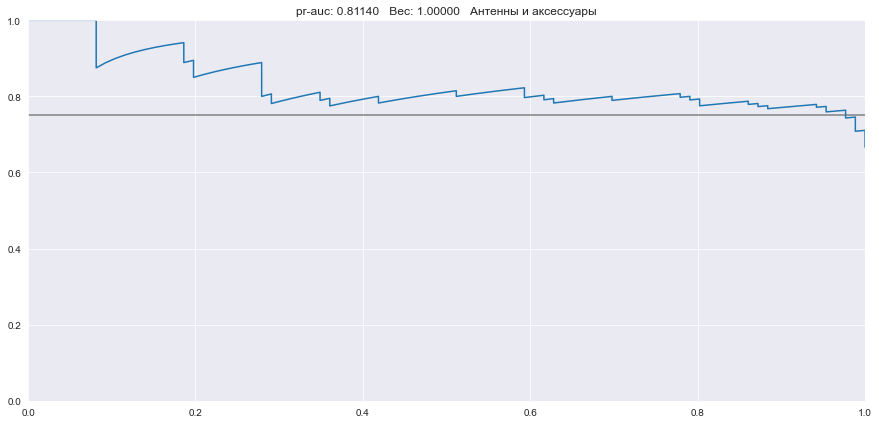

pr-auc: 0.81140   Вес: 1.00000   Антенны и аксессуары


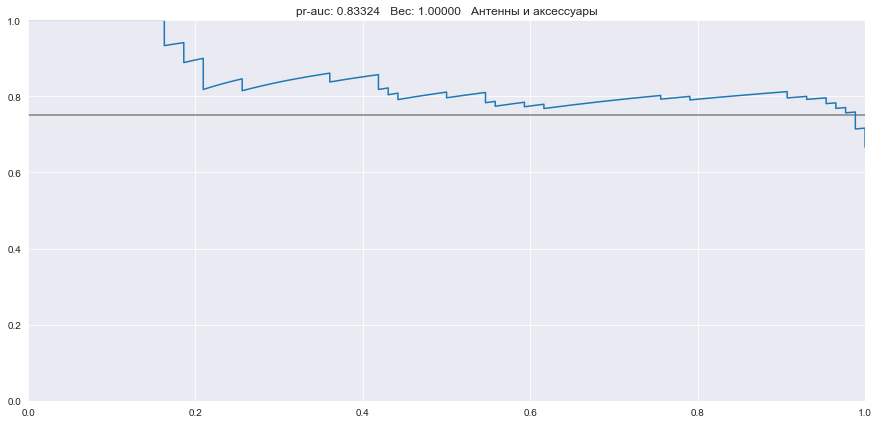

pr-auc: 0.83324   Вес: 1.00000   Антенны и аксессуары



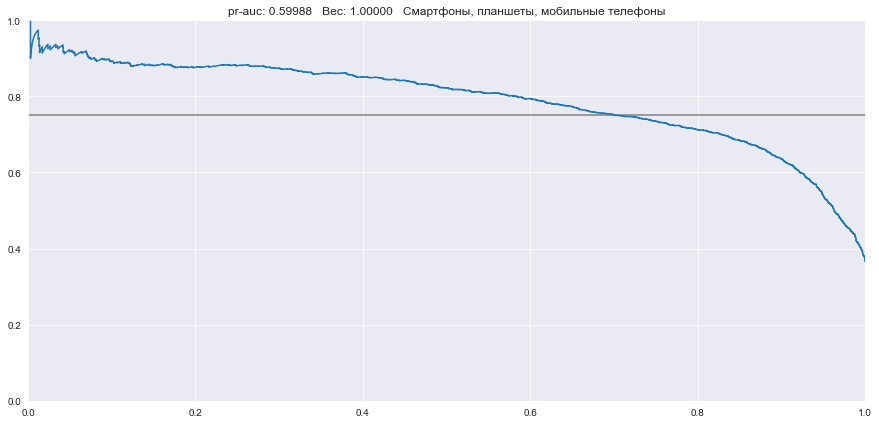

pr-auc: 0.59988   Вес: 1.00000   Смартфоны, планшеты, мобильные телефоны


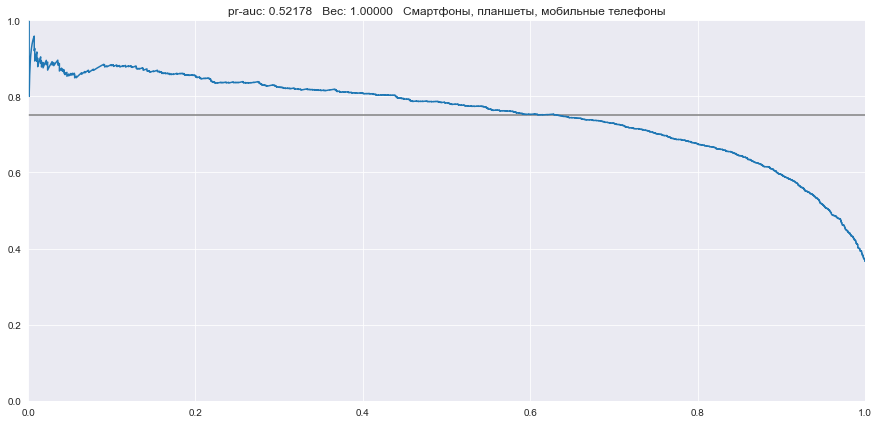

pr-auc: 0.52178   Вес: 1.00000   Смартфоны, планшеты, мобильные телефоны



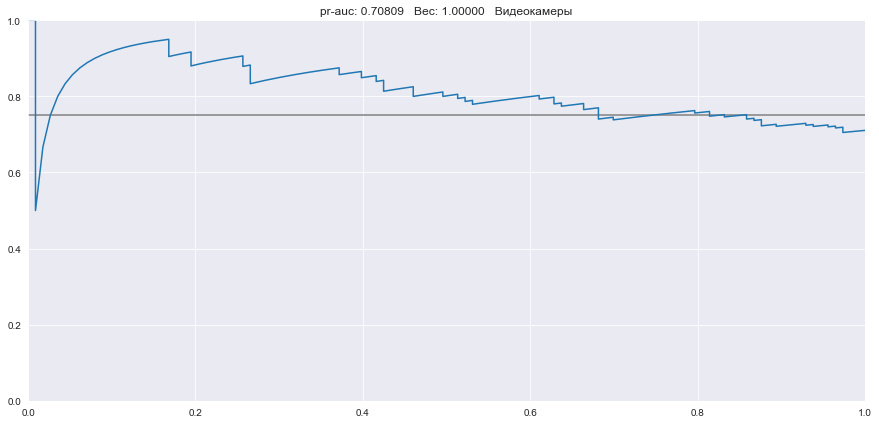

pr-auc: 0.70809   Вес: 1.00000   Видеокамеры


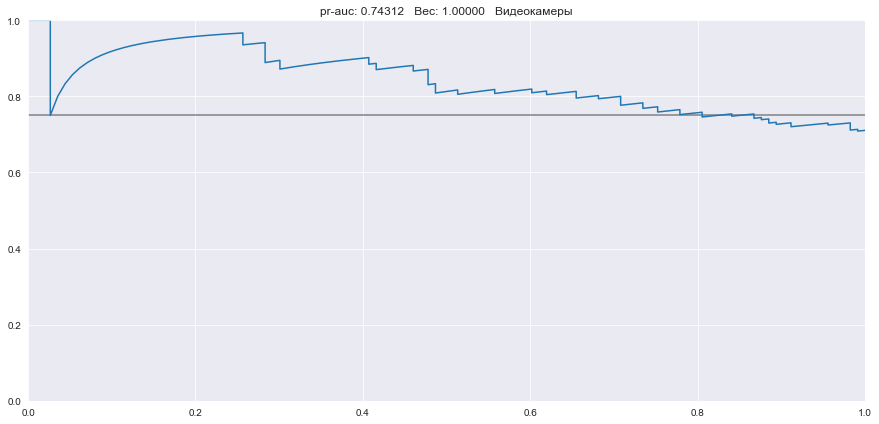

pr-auc: 0.74312   Вес: 1.00000   Видеокамеры



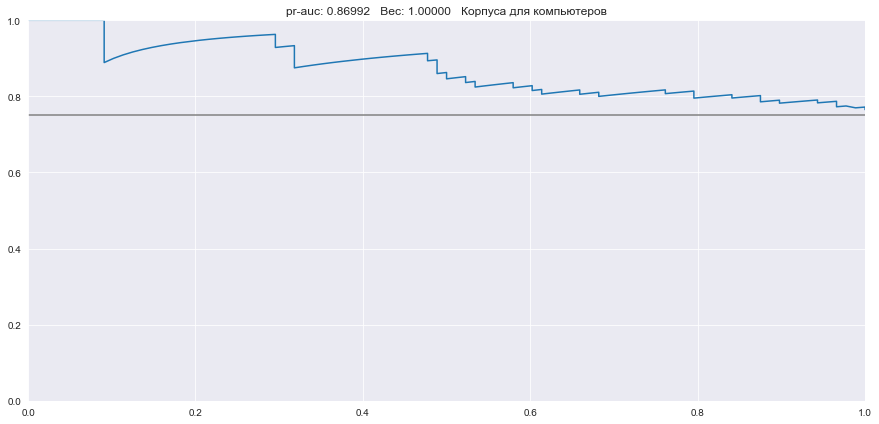

pr-auc: 0.86992   Вес: 1.00000   Корпуса для компьютеров


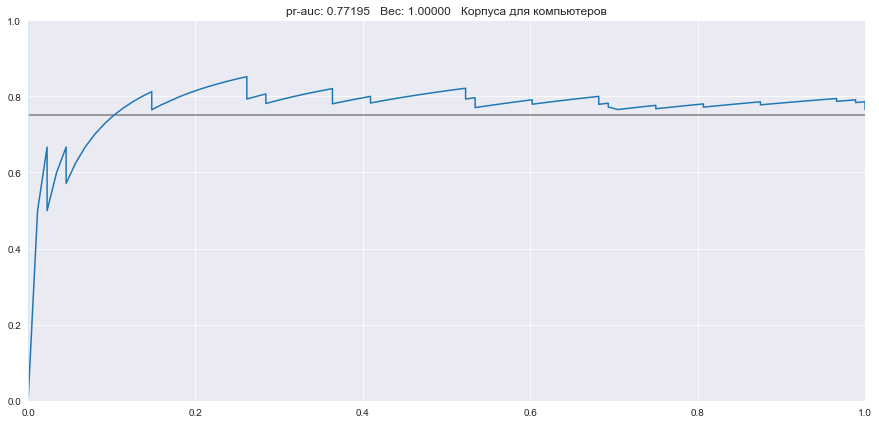

pr-auc: 0.77195   Вес: 1.00000   Корпуса для компьютеров



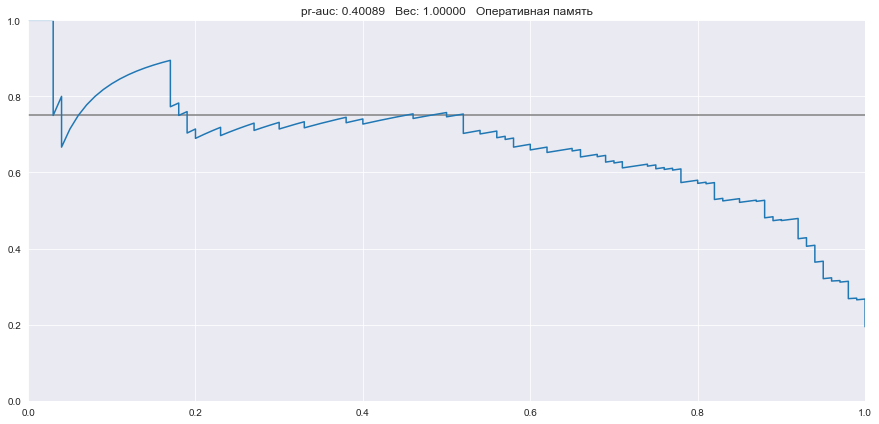

pr-auc: 0.40089   Вес: 1.00000   Оперативная память


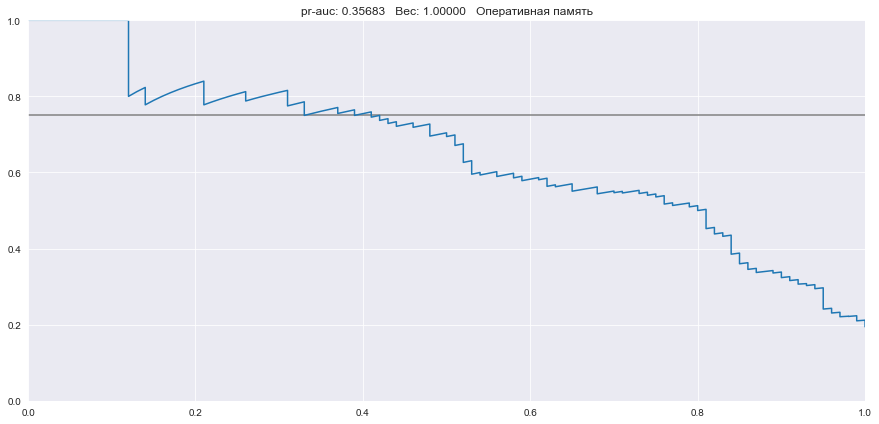

pr-auc: 0.35683   Вес: 1.00000   Оперативная память



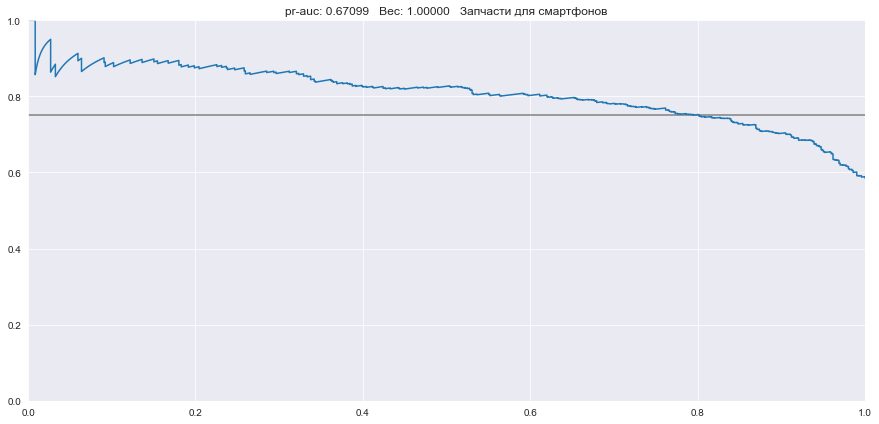

pr-auc: 0.67099   Вес: 1.00000   Запчасти для смартфонов


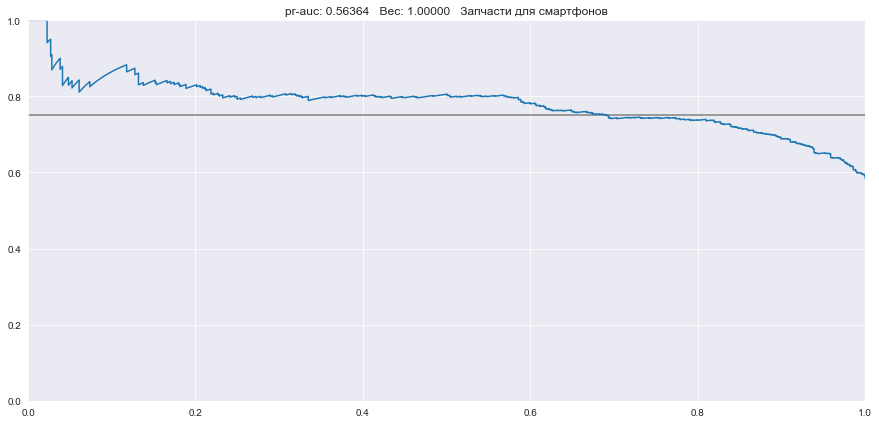

pr-auc: 0.56364   Вес: 1.00000   Запчасти для смартфонов



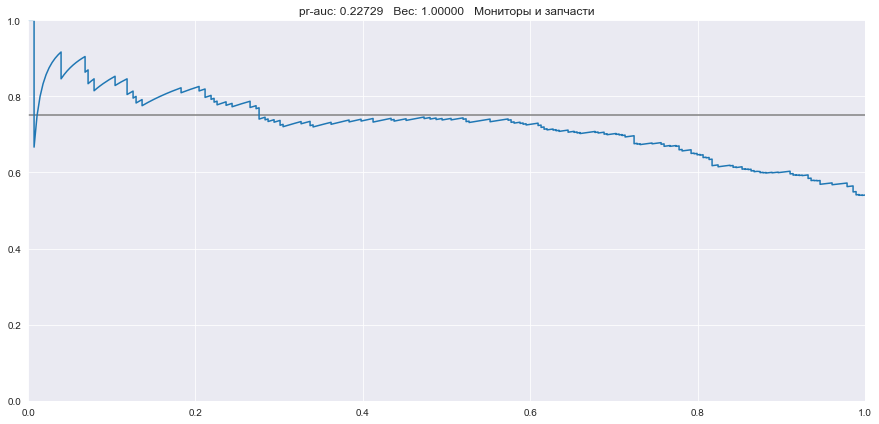

pr-auc: 0.22729   Вес: 1.00000   Мониторы и запчасти


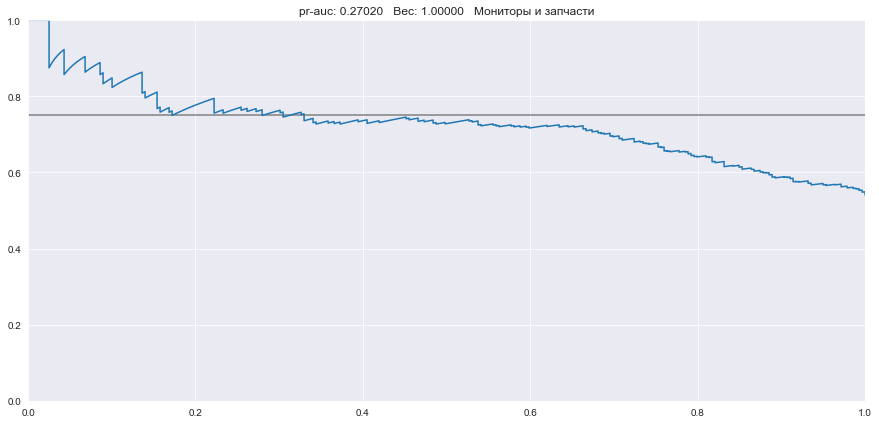

pr-auc: 0.27020   Вес: 1.00000   Мониторы и запчасти



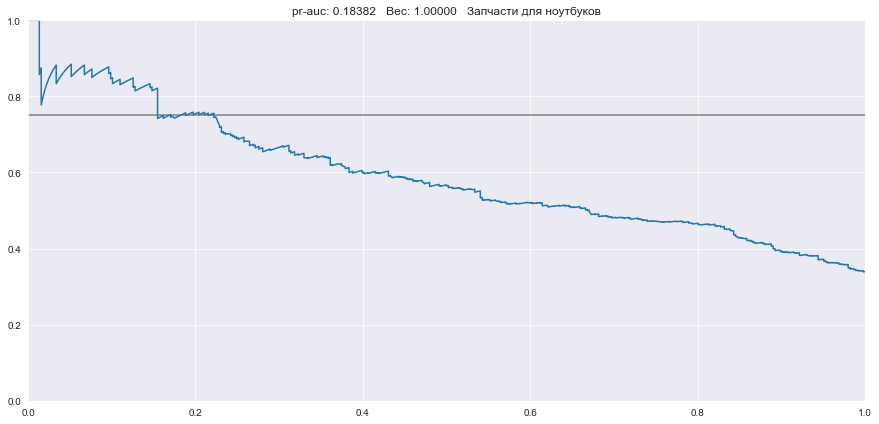

pr-auc: 0.18382   Вес: 1.00000   Запчасти для ноутбуков


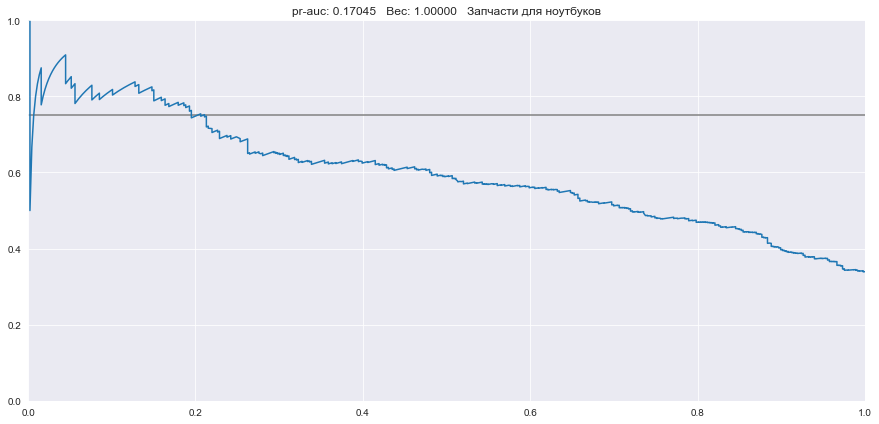

pr-auc: 0.17045   Вес: 1.00000   Запчасти для ноутбуков



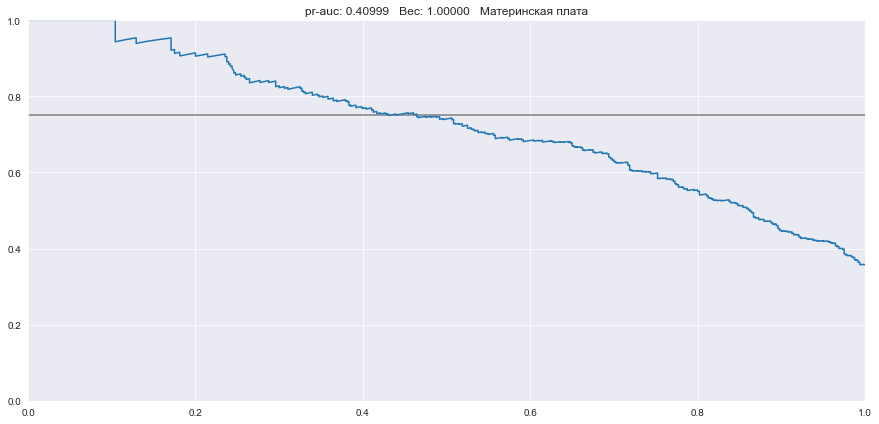

pr-auc: 0.40999   Вес: 1.00000   Материнская плата


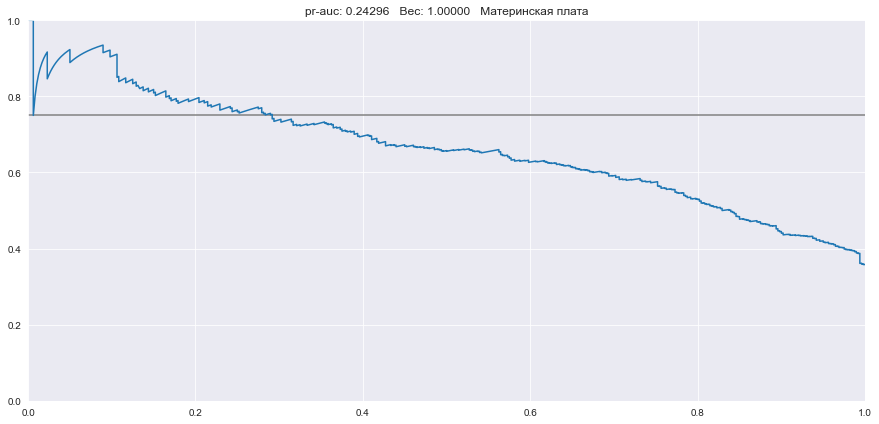

pr-auc: 0.24296   Вес: 1.00000   Материнская плата



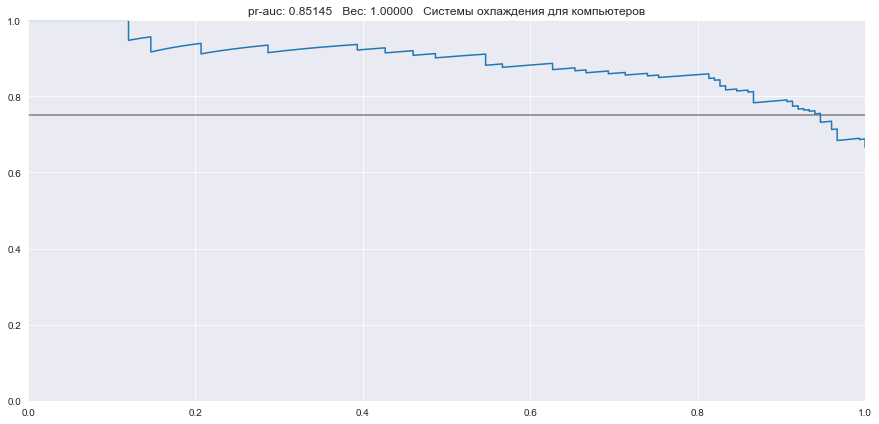

pr-auc: 0.85145   Вес: 1.00000   Системы охлаждения для компьютеров


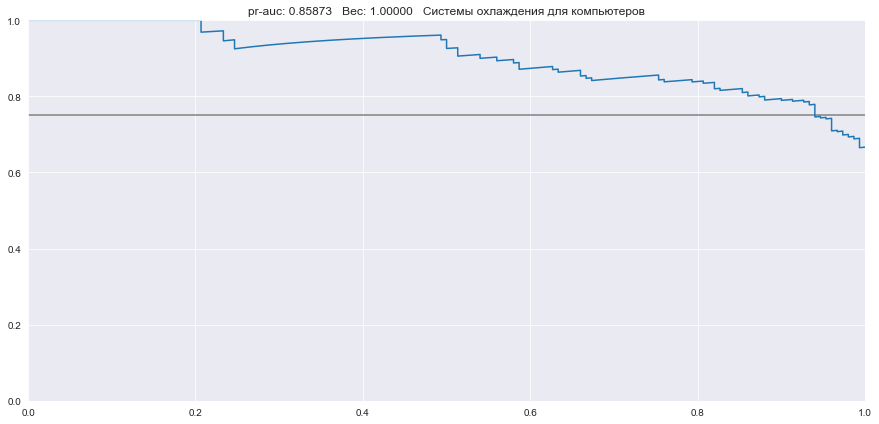

pr-auc: 0.85873   Вес: 1.00000   Системы охлаждения для компьютеров



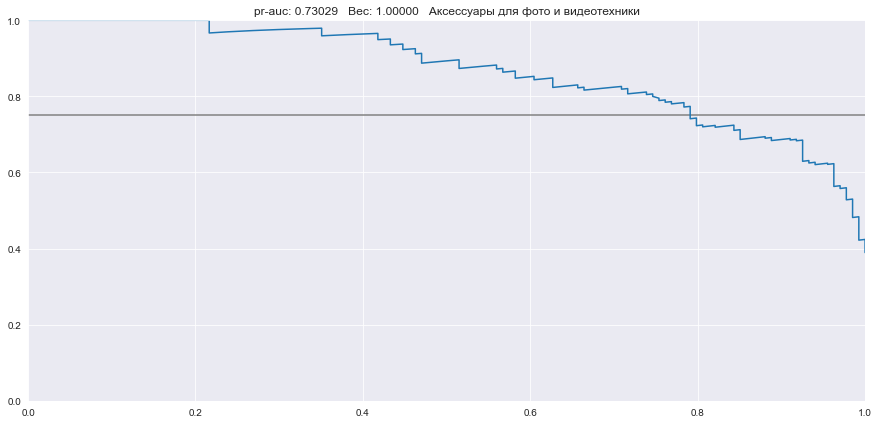

pr-auc: 0.73029   Вес: 1.00000   Аксессуары для фото и видеотехники


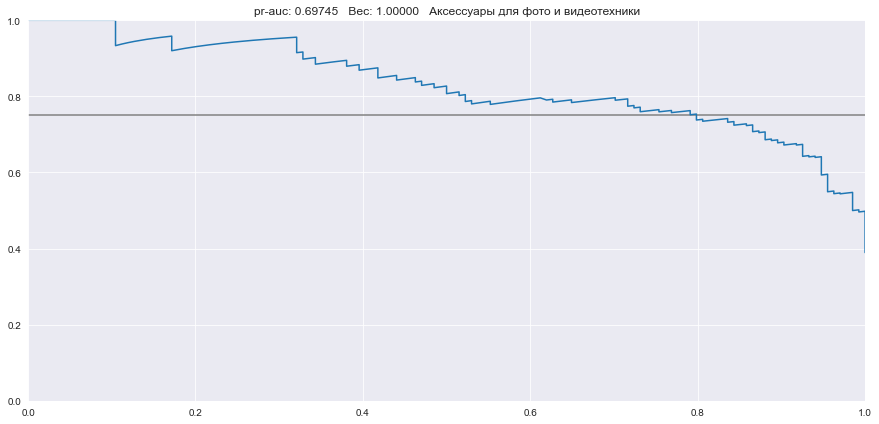

pr-auc: 0.69745   Вес: 1.00000   Аксессуары для фото и видеотехники



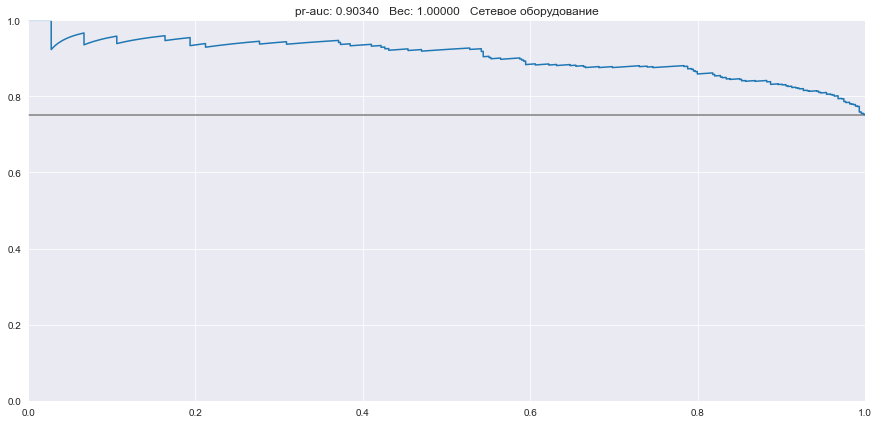

pr-auc: 0.90340   Вес: 1.00000   Сетевое оборудование


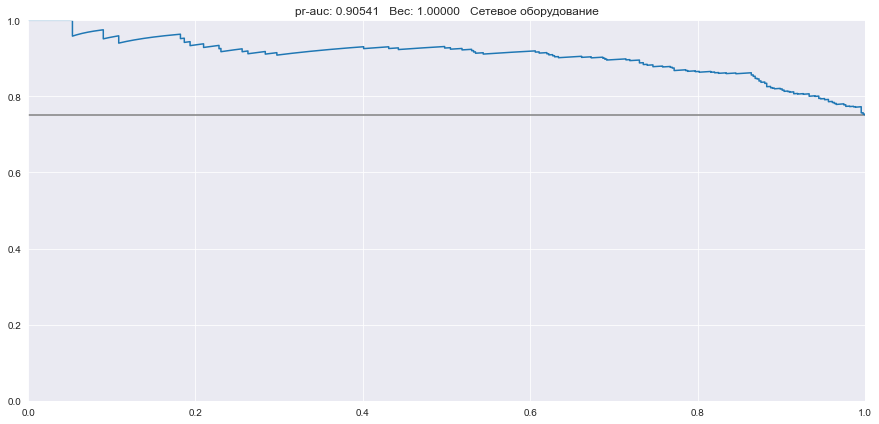

pr-auc: 0.90541   Вес: 1.00000   Сетевое оборудование



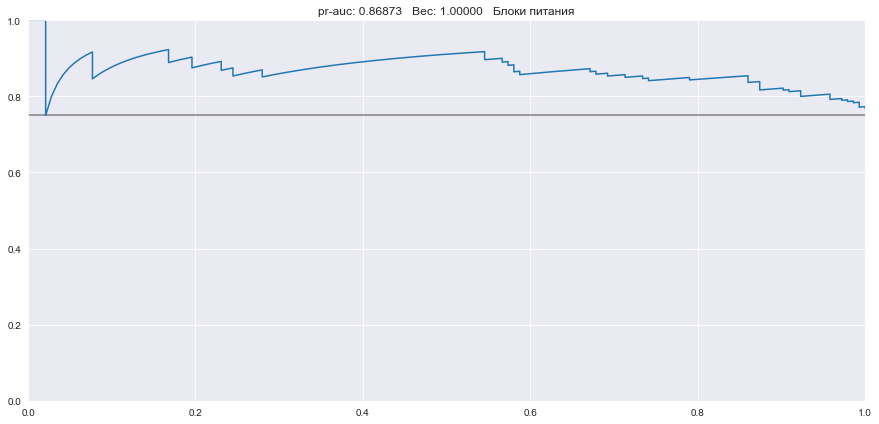

pr-auc: 0.86873   Вес: 1.00000   Блоки питания


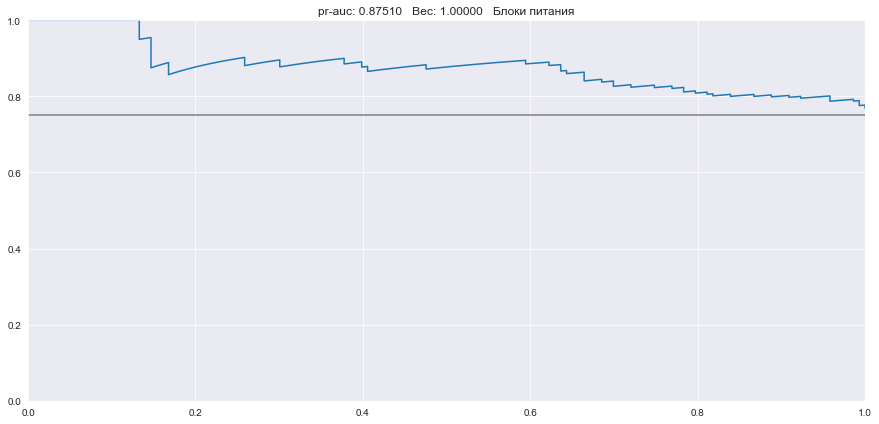

pr-auc: 0.87510   Вес: 1.00000   Блоки питания



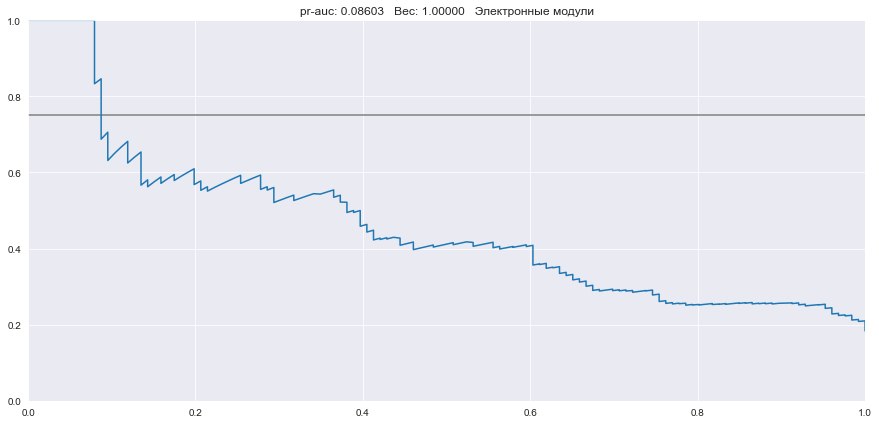

pr-auc: 0.08603   Вес: 1.00000   Электронные модули


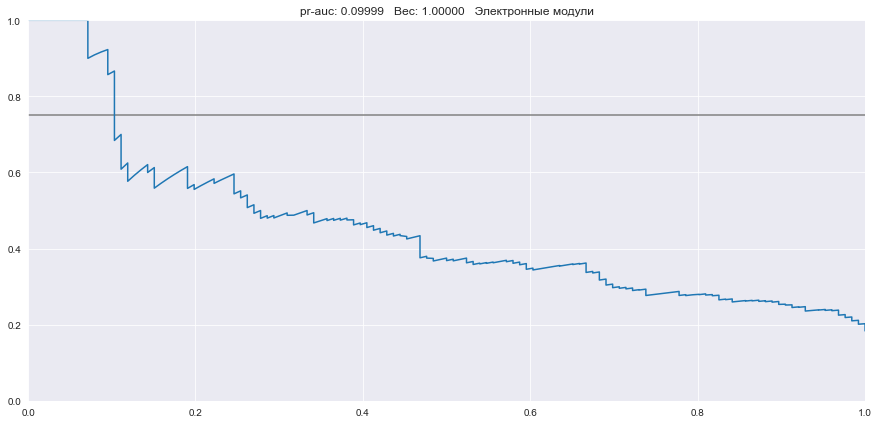

pr-auc: 0.09999   Вес: 1.00000   Электронные модули



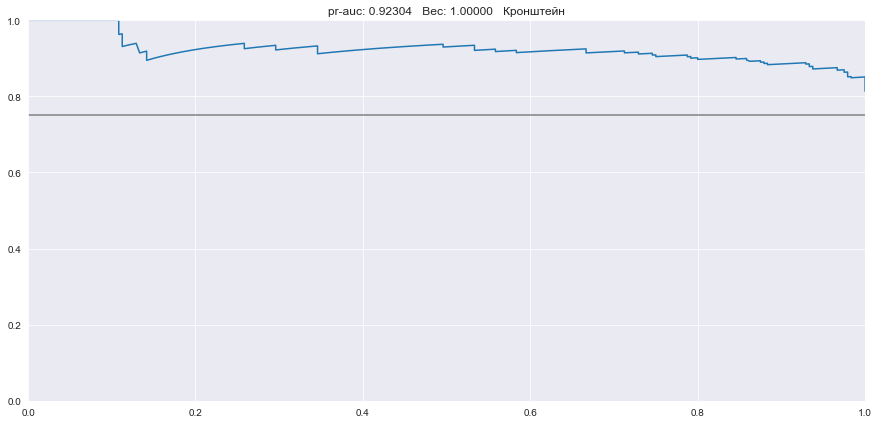

pr-auc: 0.92304   Вес: 1.00000   Кронштейн


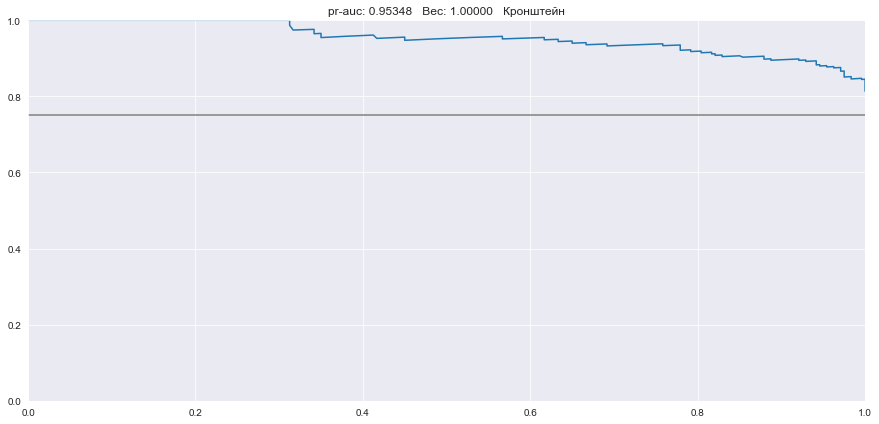

pr-auc: 0.95348   Вес: 1.00000   Кронштейн



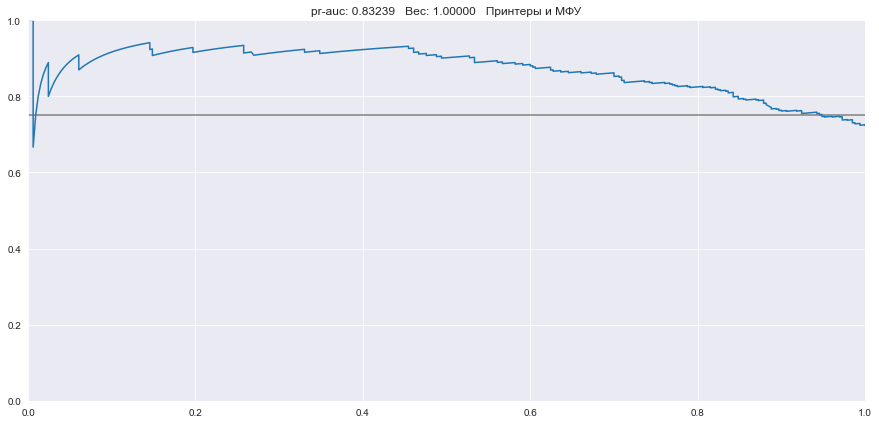

pr-auc: 0.83239   Вес: 1.00000   Принтеры и МФУ


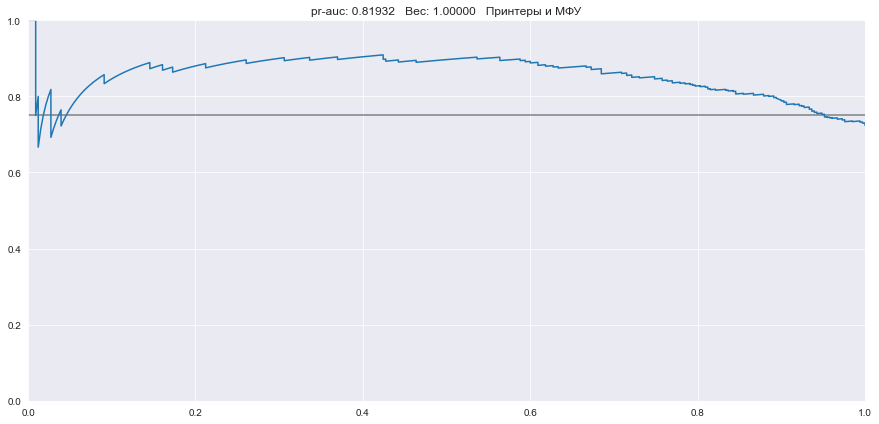

pr-auc: 0.81932   Вес: 1.00000   Принтеры и МФУ



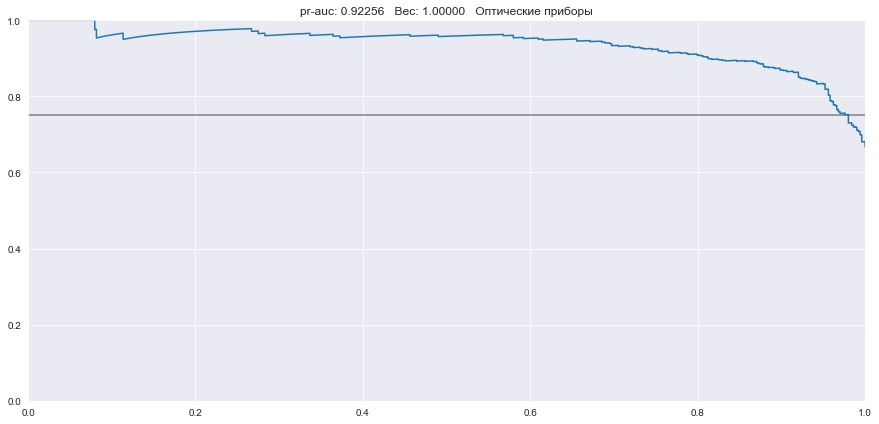

pr-auc: 0.92256   Вес: 1.00000   Оптические приборы


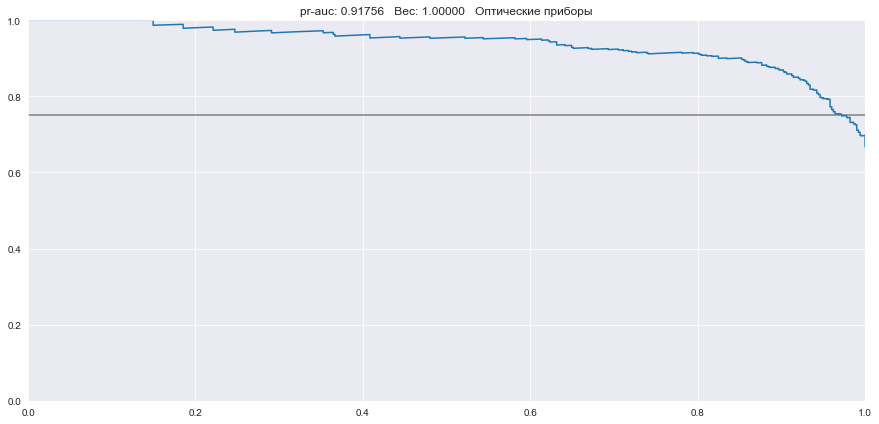

pr-auc: 0.91756   Вес: 1.00000   Оптические приборы



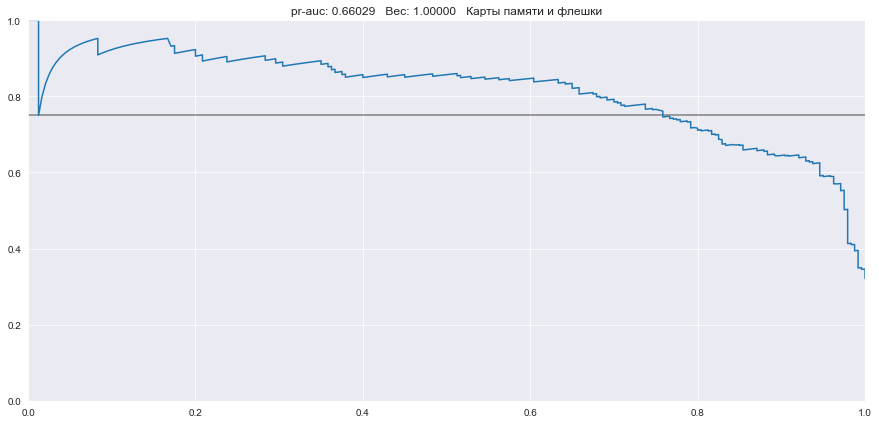

pr-auc: 0.66029   Вес: 1.00000   Карты памяти и флешки


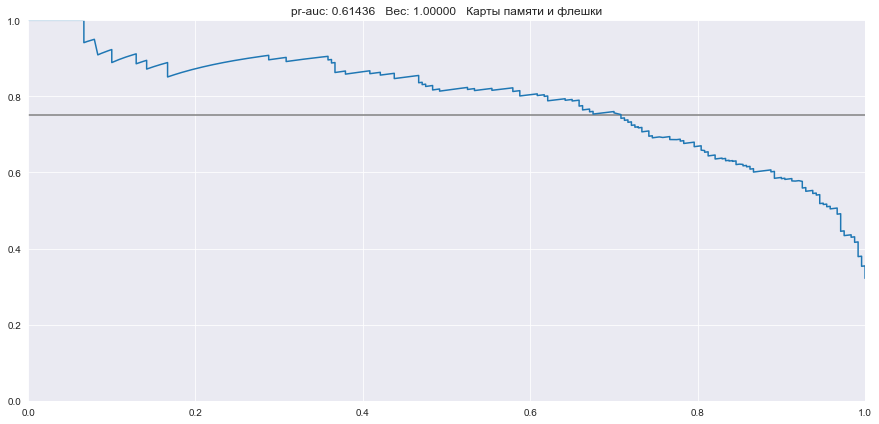

pr-auc: 0.61436   Вес: 1.00000   Карты памяти и флешки



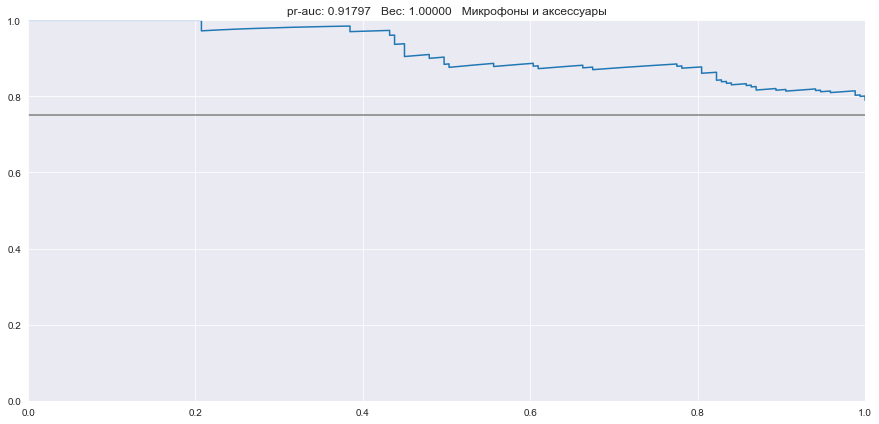

pr-auc: 0.91797   Вес: 1.00000   Микрофоны и аксессуары


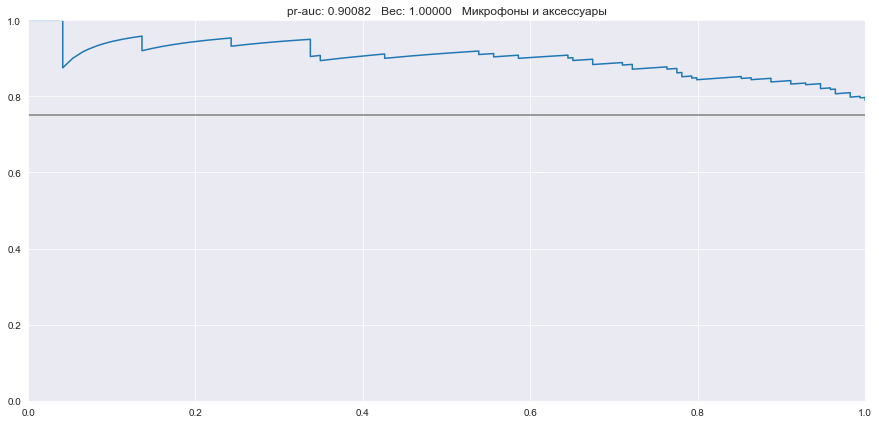

pr-auc: 0.90082   Вес: 1.00000   Микрофоны и аксессуары



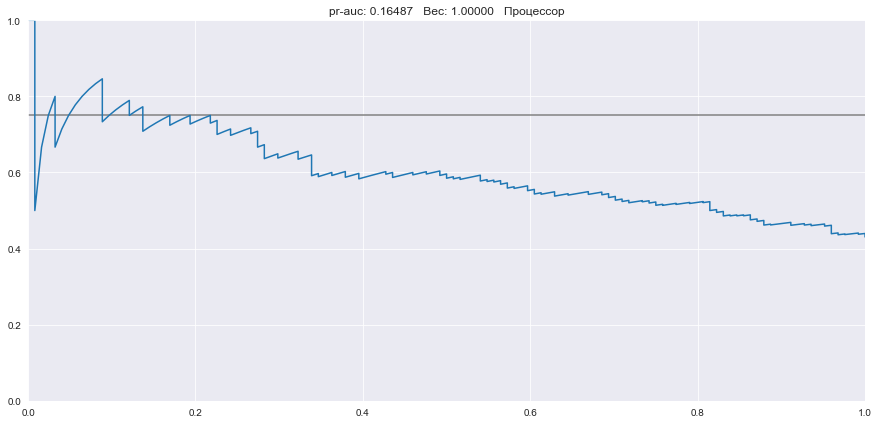

pr-auc: 0.16487   Вес: 1.00000   Процессор


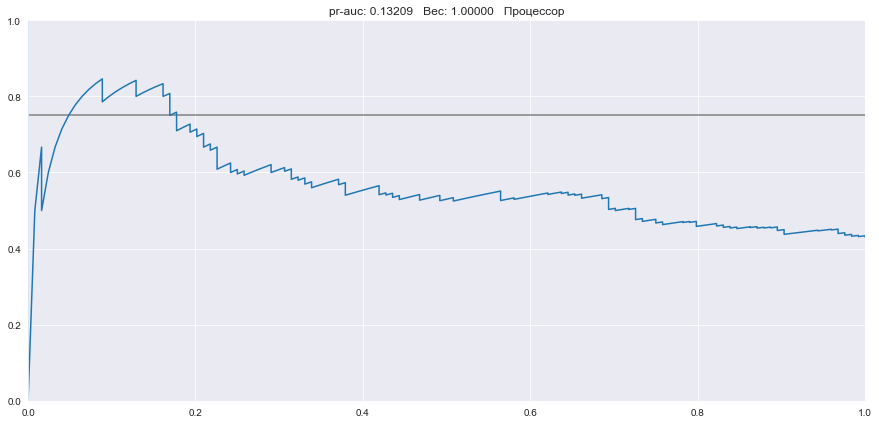

pr-auc: 0.13209   Вес: 1.00000   Процессор



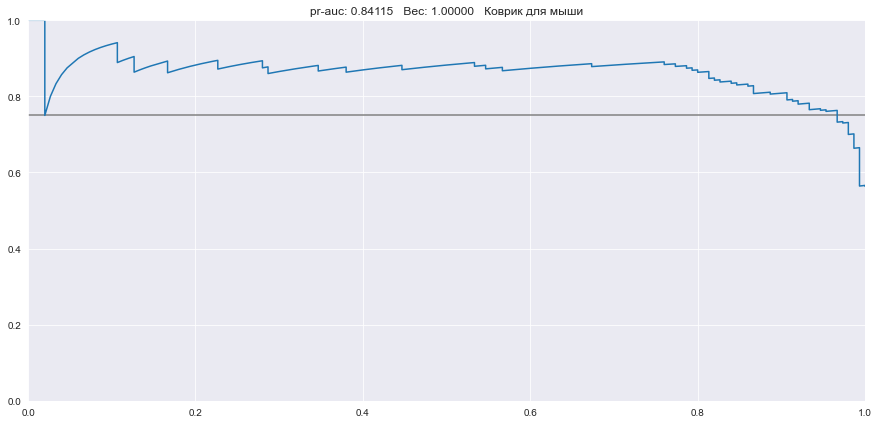

pr-auc: 0.84115   Вес: 1.00000   Коврик для мыши


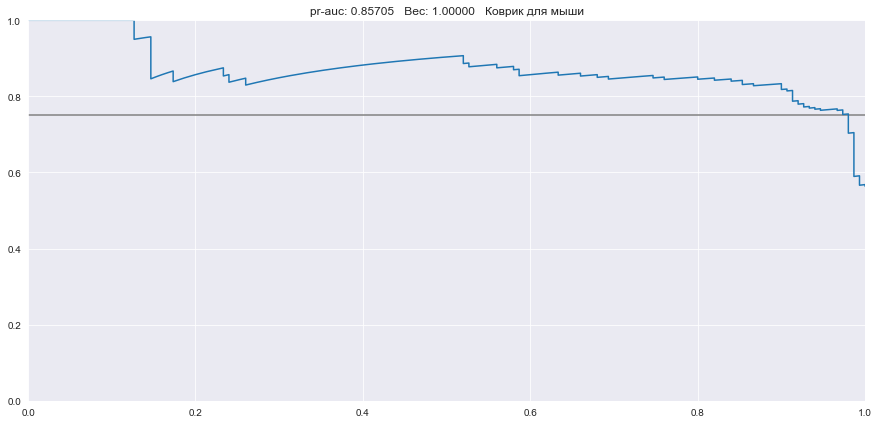

pr-auc: 0.85705   Вес: 1.00000   Коврик для мыши



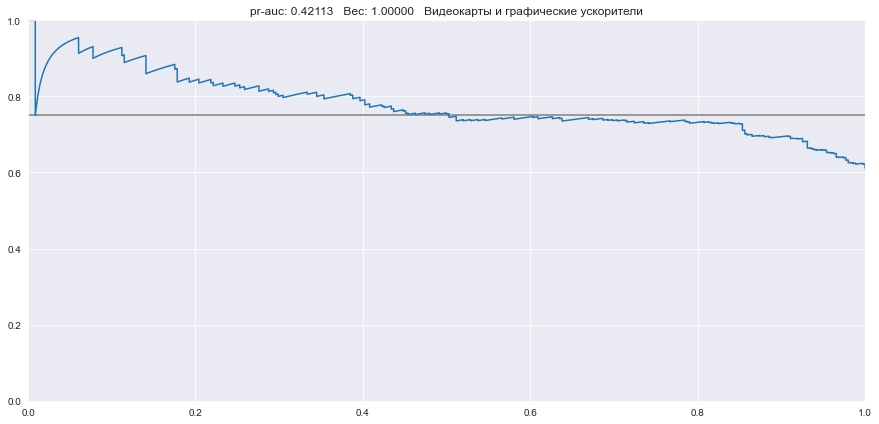

pr-auc: 0.42113   Вес: 1.00000   Видеокарты и графические ускорители


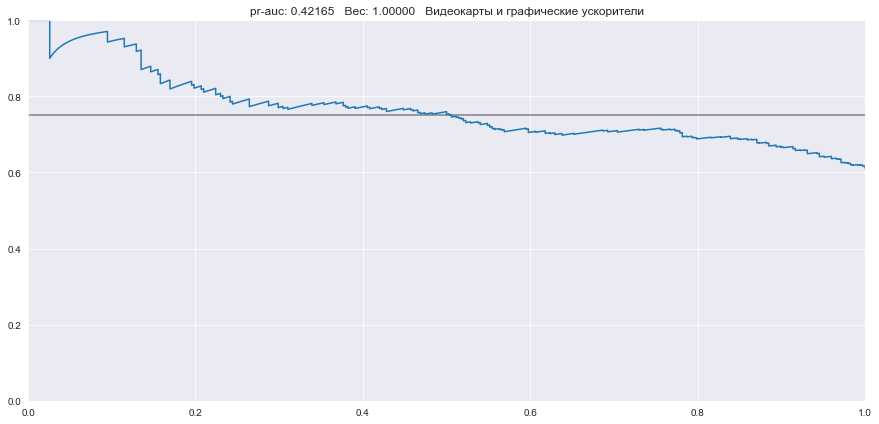

pr-auc: 0.42165   Вес: 1.00000   Видеокарты и графические ускорители



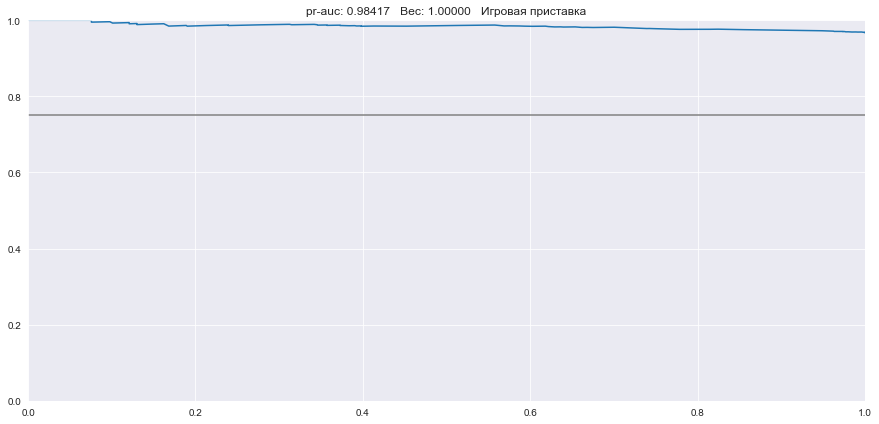

pr-auc: 0.98417   Вес: 1.00000   Игровая приставка


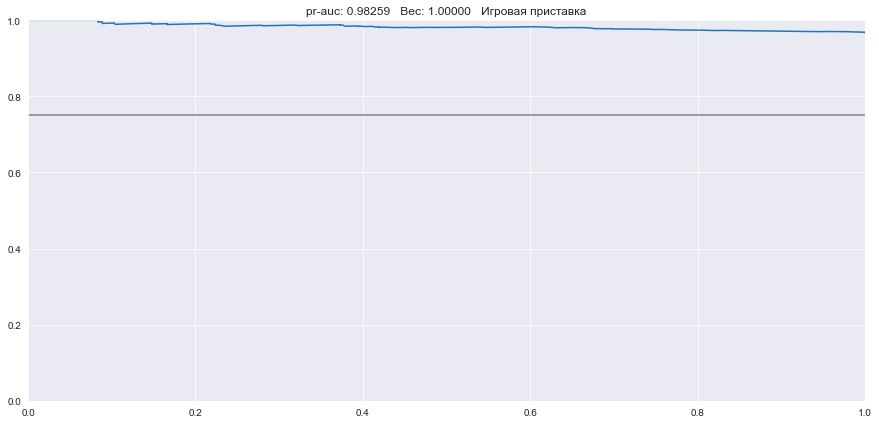

pr-auc: 0.98259   Вес: 1.00000   Игровая приставка



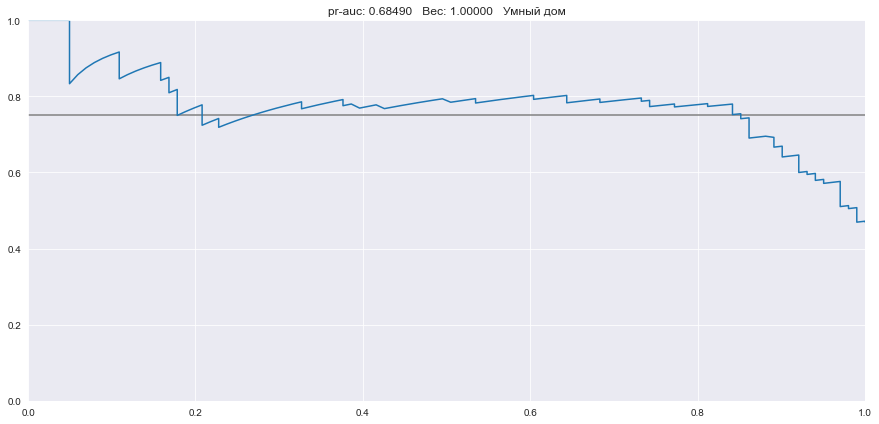

pr-auc: 0.68490   Вес: 1.00000   Умный дом


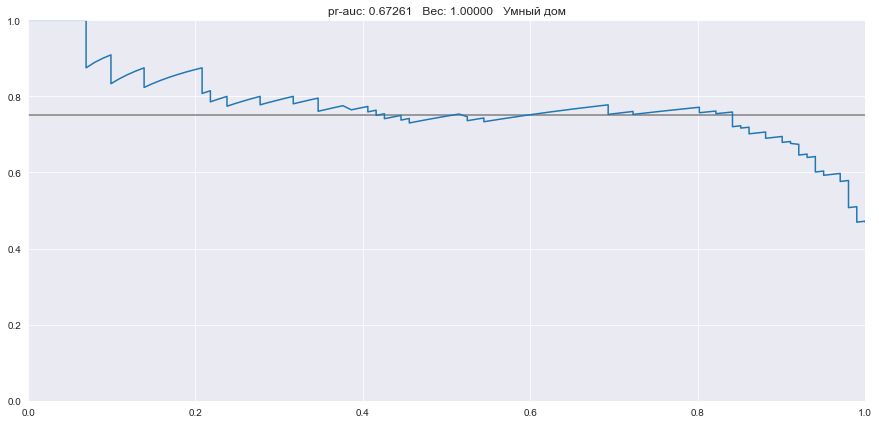

pr-auc: 0.67261   Вес: 1.00000   Умный дом



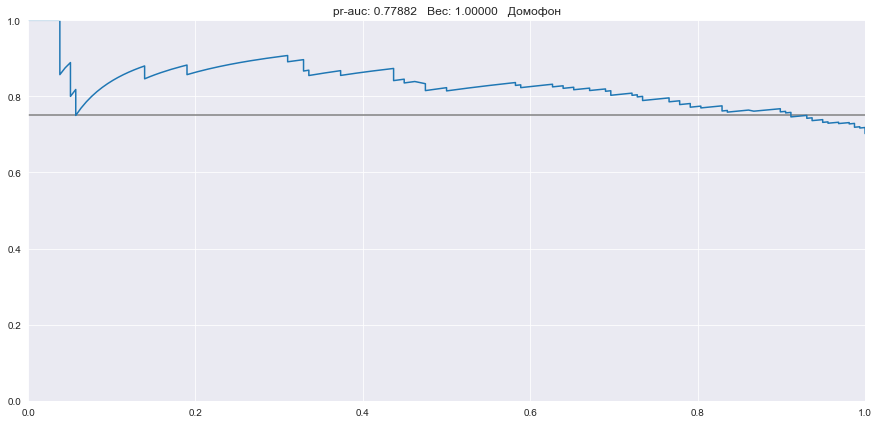

pr-auc: 0.77882   Вес: 1.00000   Домофон


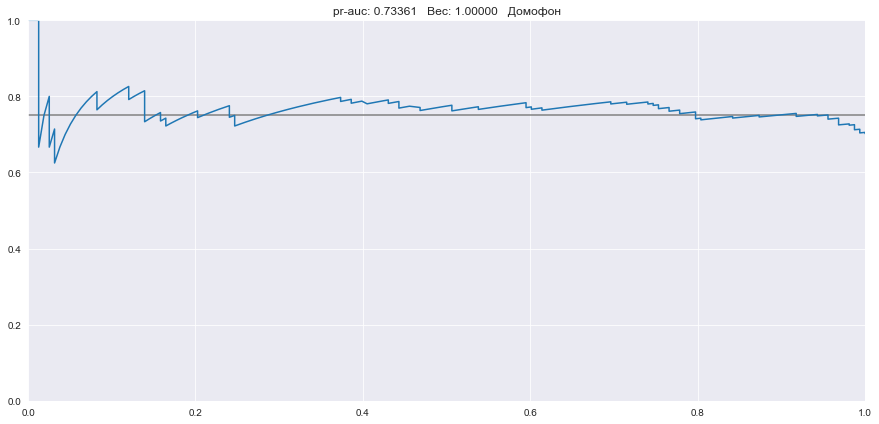

pr-auc: 0.73361   Вес: 1.00000   Домофон



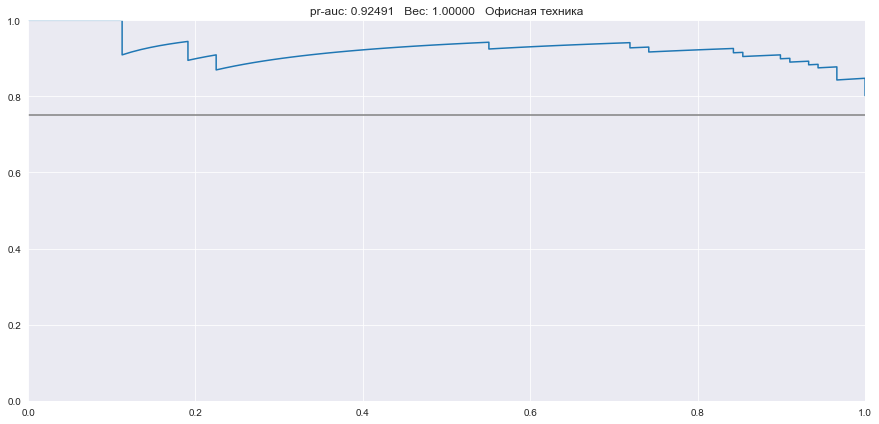

pr-auc: 0.92491   Вес: 1.00000   Офисная техника


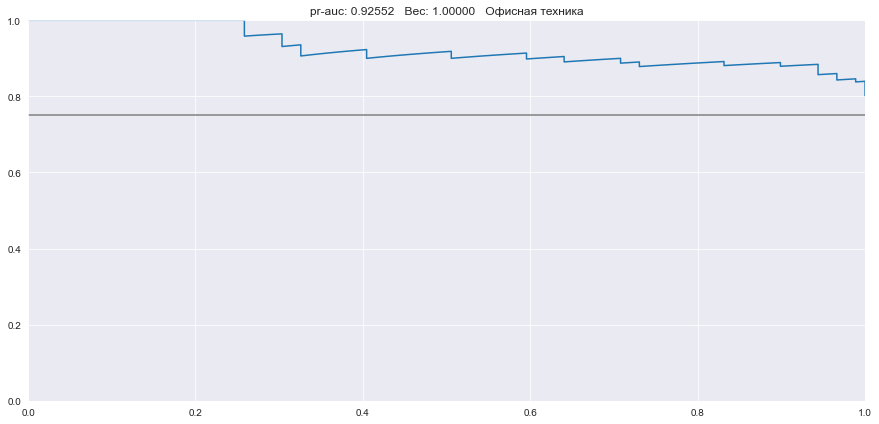

pr-auc: 0.92552   Вес: 1.00000   Офисная техника



In [17]:
model_dict = {}
#Учим в цикле модели по разным категориям и валидируем
cntr = 0
for category in data['cat3_grouped_x'].unique():
    #На каждый проход цикла выбираем только определенную категорию
    data_category = data[data['cat3_grouped_x'] == category]
    
    model_dict[category] = np.ones(4, dtype=object) #добавляем в словарь ключ и заглушку
    #Бьем на трейн и тест
    x_train, x_test = train_test_split(data_category, 
                                       random_state=42, 
                                       test_size=0.2, 
                                       stratify=data_category[['cat3_grouped_x','target']])
    #Сбрасываем индексы 
    x_train.reset_index(drop=True, inplace=True) 
    x_test.reset_index(drop=True, inplace=True)
    
    
    y_train = x_train['target'].copy() # таргет для набора с суммированными векторами
    y_test = x_test['target'].copy() #таргет для теста
    
#     print(y_train.count())

    #инициализируем и обучаем векторайзер на всех предварительно очищенных текстах
    vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+[-.]*\w+\b')
    vectorizer.fit(pd.concat([x_train['cleaned_x'],x_train['cleaned_y']]))
    
    model_dict[category][0] = vectorizer #кладем векторайзер в словарь
    
    cleaned_1_vectorized = vectorizer.transform(x_train['cleaned_x']) #векторизуем тексты первого товара
    cleaned_2_vectorized = vectorizer.transform(x_train['cleaned_y']) #векторизуем тексты второго товара
    x_train_con = hstack((cleaned_1_vectorized, cleaned_2_vectorized)) #конкатенируем
    
    cleaned_1_vectorized_test = vectorizer.transform(x_test['cleaned_x']) #векторизуем тексты первого товара теста
    cleaned_2_vectorized_test = vectorizer.transform(x_test['cleaned_y']) #векторизуем тексты второго товара теста
    x_test_con = hstack((cleaned_1_vectorized_test, cleaned_2_vectorized_test)) #конкатенируем
    
    x_train_sum = cleaned_1_vectorized + cleaned_2_vectorized #суммируем по трейну
    x_test_sum = cleaned_1_vectorized_test + cleaned_2_vectorized_test #суммируем по тесту
    
    #обучаем на атрибутах
    vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+[-.]*\w+\b')
    vectorizer.fit(pd.concat([x_train['characteristic_attributes_mapping_x'],x_train['characteristic_attributes_mapping_y']])) 
    model_dict[category][2] = vectorizer #кладем векторайзер в словарь
    
    atr_1_vectorized = vectorizer.transform(x_train['characteristic_attributes_mapping_x']) #векторизуем атрибуты первого товара
    atr_2_vectorized = vectorizer.transform(x_train['characteristic_attributes_mapping_y']) #векторизуем атрибуты второго товара
    atr_con = hstack((atr_1_vectorized, atr_2_vectorized)) #конкатенируем атрибуты трейна
    atr_sum = atr_1_vectorized + atr_2_vectorized #суммируем атрибуты трейна
    
    atr_1_vectorized_test = vectorizer.transform(x_test['characteristic_attributes_mapping_x']) #векторизуем атрибуты первого товара
    atr_2_vectorized_test = vectorizer.transform(x_test['characteristic_attributes_mapping_y']) #векторизуем атрибуты второго товара
    atr_con_test = hstack((atr_1_vectorized_test, atr_2_vectorized_test)) #конкатенируем атрибуты теста
    atr_sum_test = atr_1_vectorized_test + atr_2_vectorized_test #суммируем атрибуты теста
    
    x_train_con = hstack((x_train_con, atr_con)) #конкатенируем атрибуты с текстами для модели с конкатенированными векторами - трейн
    x_train_sum = hstack((x_train_sum, atr_sum)) #конкатенируем атрибуты с текстами для модели с суммированными векторами - трейн
    x_test_con = hstack((x_test_con, atr_con_test)) #конкатенируем атрибуты с текстами для модели с конкатенированными векторами - тест
    x_test_sum = hstack((x_test_sum, atr_sum_test)) #конкатенируем атрибуты с текстами для модели с суммированными векторами - тест
    
    
    #считаем косинус и эвклид
    
    #конкатенируем отдельно векторы 1ых и 2ых товаров
    name_atr_vectorized_1_train = hstack((cleaned_1_vectorized, atr_1_vectorized))
    name_atr_vectorized_2_train = hstack((cleaned_2_vectorized, atr_2_vectorized))
    name_atr_vectorized_1_test = hstack((cleaned_1_vectorized_test, atr_1_vectorized_test))
    name_atr_vectorized_2_test = hstack((cleaned_2_vectorized_test, atr_2_vectorized_test))
    
    #считаем косинус
    cos_sim_train = []
    for i in range(name_atr_vectorized_1_train.shape[0]):
        cos_sim = cosine(name_atr_vectorized_1_train[i].toarray(), name_atr_vectorized_2_train[i].toarray())
        cos_sim_train.append(cos_sim)
    cos_sim_train = np.array(cos_sim_train)
    
    cos_sim_test = []
    for i in range(name_atr_vectorized_1_test.shape[0]):
        cos_sim = cosine(name_atr_vectorized_1_test[i].toarray(), name_atr_vectorized_2_test[i].toarray())
        cos_sim_test.append(cos_sim)
    cos_sim_test = np.array(cos_sim_test)
    
    #считаем эвклид
    euc_dist_train = []
    for i in range(name_atr_vectorized_1_train.shape[0]):
        a = np.squeeze(name_atr_vectorized_1_train[i].toarray())
        b = np.squeeze(name_atr_vectorized_2_train[i].toarray())
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_train.append(np.sqrt(sum(squared_diffs)))
    euc_dist_train = np.array(euc_dist_train)
    
    euc_dist_test = []
    for i in range(name_atr_vectorized_1_test.shape[0]):
        a = np.squeeze(name_atr_vectorized_1_test[i].toarray())
        b = np.squeeze(name_atr_vectorized_2_test[i].toarray())
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_test.append(np.sqrt(sum(squared_diffs)))
    euc_dist_test = np.array(euc_dist_test)
    
    #совмешаем и транспонируем матрицы
    dist_train = np.vstack([cos_sim_train,euc_dist_train]).T
    dist_test = np.vstack([cos_sim_test,euc_dist_test]).T
    #переводим в спарс
    dist_train_sparse = sp.csr_matrix(dist_train)
    dist_test_sparse = sp.csr_matrix(dist_test)
    #конкатенируем
    x_train_con = hstack([x_train_con, dist_train_sparse])
    x_test_con = hstack([x_test_con, dist_test_sparse])
    x_train_sum = hstack([x_train_sum, dist_train_sparse])
    x_test_sum = hstack([x_test_sum, dist_test_sparse])
    
    train_img_1, train_img_2 = features_to_numpy(x_train[['main_pic_embeddings_resnet_v1_x','main_pic_embeddings_resnet_v1_y']])
    test_img_1, test_img_2 = features_to_numpy(x_test[['main_pic_embeddings_resnet_v1_x','main_pic_embeddings_resnet_v1_y']])
    
    #считаем косинус
    cos_sim_img_train = []
    for i in range(train_img_1.shape[0]):
        cos_sim = cosine(train_img_1[i], train_img_2[i])
        cos_sim_img_train.append(cos_sim)
    cos_sim_img_train = np.array(cos_sim_train)
    
    cos_sim_img_test = []
    for i in range(test_img_1.shape[0]):
        cos_sim = cosine(test_img_1[i], test_img_2[i])
        cos_sim_img_test.append(cos_sim)
    cos_sim_img_test = np.array(cos_sim_img_test)
    
    #считаем эвклид
    euc_dist_img_train = []
    for i in range(train_img_1.shape[0]):
        a = np.squeeze(train_img_1[i])
        b = np.squeeze(train_img_2[i])
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_img_train.append(np.sqrt(sum(squared_diffs)))
    euc_dist_img_train = np.array(euc_dist_img_train)
    
    euc_dist_img_test = []
    for i in range(test_img_1.shape[0]):
        a = np.squeeze(test_img_1[i])
        b = np.squeeze(test_img_2[i])
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_img_test.append(np.sqrt(sum(squared_diffs)))
    euc_dist_img_test = np.array(euc_dist_img_test)
    
    #совмешаем и транспонируем матрицы
    dist_img_train = np.vstack([cos_sim_img_train,euc_dist_img_train]).T
    dist_img_test = np.vstack([cos_sim_img_test,euc_dist_img_test]).T
    #переводим в спарс
    dist_img_train_sparse = sp.csr_matrix(dist_img_train)
    dist_img_test_sparse = sp.csr_matrix(dist_img_test)
    #конкатенируем
    x_train_con = hstack([x_train_con, dist_img_train_sparse])
    x_test_con = hstack([x_test_con, dist_img_test_sparse])
    x_train_sum = hstack([x_train_sum, dist_img_train_sparse])
    x_test_sum = hstack([x_test_sum, dist_img_test_sparse])
    
    
    
    #проверка суммированных векторов
    model_sum = ltb.LGBMClassifier(max_depth=15, n_estimators=500, random_state=42)
#     model_sum = LogisticRegression(max_iter=10000, random_state=42, C=1)
    model_sum.fit(x_train_sum, y_train)
#     preds = model_sum.predict(x_test_sum)
#     print('Суммированные векторы')
#     f1_sum = f1_score(y_test, preds) # запоминаем результат категории
#     print('Precision',precision_score(y_test, preds))
#     print('Recall',recall_score(y_test, preds))
#     print('F1',f1_score(y_test, preds))
    
    preds = model_sum.predict_proba(x_test_sum)[:,1]
    predictions_df = x_test.drop('target', axis=1).copy()
    predictions_df['scores'] = preds
    target_df = x_test.copy()
    target_df['target'] = y_test
    target_df['cat3_grouped'] = target_df['cat3_grouped_x']
    
    prauc_con = pr_auc_macro(
        target_df, 
        predictions_df,
        prec_level=0.75,
        cat_column="cat3_grouped")
    
    
    
    #проверяем конкатенированные векторы
#     model_con = LogisticRegression(max_iter=10000, random_state=42, C=1)
    model_con = ltb.LGBMClassifier(max_depth=15, n_estimators=500, random_state=42)
    model_con.fit(x_train_con, y_train)
    preds = model_con.predict(x_test_con)
    
#     print('Конкатенированные векторы')
#     f1_con = f1_score(y_test, preds) # запоминаем результат категории по конкатенированным векторам
#     print('Precision',precision_score(y_test, preds))
#     print('Recall',recall_score(y_test, preds))
#     print('F1',f1_score(y_test, preds))
    
    preds = model_con.predict_proba(x_test_con)[:,1]
    predictions_df = x_test.drop('target', axis=1).copy()
    predictions_df['scores'] = preds
    target_df = x_test.copy()
    target_df['target'] = y_test
    target_df['cat3_grouped'] = target_df['cat3_grouped_x']
    
    prauc_sum = pr_auc_macro(
        target_df, 
        predictions_df,
        prec_level=0.75,
        cat_column="cat3_grouped")


    #лучшая модель идет в словарик
    if prauc_con >= prauc_sum:
        model_dict[category][1] = model_con
        model_dict[category][3] = 'конкатенированные'
    else:
        model_dict[category][1] = model_sum
        model_dict[category][3] = 'суммированные'
    

# проверяем с семплированием
#     print('\nАпсемплинг\n')
#     sampler = SMOTETomek(sampling_strategy='all',
#                          random_state=42)

#     x_train_sum_us, y_train_sum_us = sampler.fit_resample(x_train_sum, y_train)
#     x_train_con_us, y_train_con_us = sampler.fit_resample(x_train_con, y_train)
    
#     model_sum_us = LogisticRegression(max_iter=10000, random_state=42, C=1)
#     model_sum_us.fit(x_train_sum_us, y_train_sum_us)
#     preds = model_sum_us.predict(x_test_sum)
#     print('Суммированные векторы')
    
#     f1_sum = f1_score(y_test, preds) # запоминаем результат категории
#     print('Precision',precision_score(y_test, preds))
#     print('Recall',recall_score(y_test, preds))
#     print('F1',f1_score(y_test, preds))
    
#     preds = model_sum_us.predict_proba(x_test_sum)[:,1]
#     predictions_df = x_test.drop('target', axis=1).copy()
#     predictions_df['scores'] = preds
#     target_df = x_test.copy()
#     target_df['target'] = y_test
#     target_df['cat3_grouped'] = target_df['cat3_grouped_x']
#     pr_auc_macro(
#         target_df, 
#         predictions_df,
#         prec_level=0.75,
#         cat_column="cat3_grouped")
    
#     #проверяем конкатенированные векторы
#     print('\nКонкатенированные векторы')
#     model_con_us = LogisticRegression(max_iter=10000, random_state=42, C=1)
#     model_con_us.fit(x_train_con_us, y_train_con_us)
#     preds = model_con_us.predict(x_test_con)

#     f1_con = f1_score(y_test, preds) # запоминаем результат категории по конкатенированным векторам
#     print('Precision',precision_score(y_test, preds))
#     print('Recall',recall_score(y_test, preds))
#     print('F1',f1_score(y_test, preds))
    
#     preds = model_con_us.predict_proba(x_test_con)[:,1]
#     predictions_df = x_test.drop('target', axis=1).copy()
#     predictions_df['scores'] = preds
#     target_df = x_test.copy()
#     target_df['target'] = y_test
#     target_df['cat3_grouped'] = target_df['cat3_grouped_x']
#     pr_auc_macro(
#         target_df, 
#         predictions_df,
#         prec_level=0.75,
#         cat_column="cat3_grouped")
    
    print()

In [18]:
prauc_con

0.9249099856279122

In [19]:
***

SyntaxError: invalid syntax (2938429678.py, line 1)

При прохождении цикла на валидации будут сравниваться модели с апсемплингом по конкатенированным векторам и по суммированным векторам. Модель с бОльшим f1 добавляется в словарь, где ключ - название категории, а значение - обученные на этой категории векторайзер и модель

Тест при предикте делится на отдельные категории, каждая категория проходит через свою модель. Затем результаты конкатенируются

### Валидируем на всем x_test и проверяем что нигде не ошиблись

In [ ]:
model_dict

In [20]:
cntr = 0
for category in model_dict: #проходимся циклом по словарю
    
    data_category = data[data['cat3_grouped_x'] == category] #выделяем категорию из данных
    
    x_train, x_test = train_test_split(data_category, 
                                       random_state=42, 
                                       test_size=0.2, 
                                       stratify=data_category[['cat3_grouped_x','target']])
    
    y_test = x_test['target'].copy() 
    
    vectorizer = model_dict[category][0] #достаем векторайзер имен из словаря
    model = model_dict[category][1] #достаем модель из словаря
    
    cleaned_1_vectorized = vectorizer.transform(x_test['cleaned_x']) #векторизуем тексты первого товара
    cleaned_2_vectorized = vectorizer.transform(x_test['cleaned_y']) #векторизуем тексты второго товара
    
    vectorizer = model_dict[category][2] #достаем векторайзер атрибутов из словаря
    
    atr_1_vectorized_test = vectorizer.transform(x_test['characteristic_attributes_mapping_x']) #векторизуем атрибуты первого товара
    atr_2_vectorized_test = vectorizer.transform(x_test['characteristic_attributes_mapping_y']) #векторизуем атрибуты второго товара
    atr_con_test = hstack((atr_1_vectorized_test, atr_2_vectorized_test)) #конкатенируем атрибуты теста
    atr_sum_test = atr_1_vectorized_test + atr_2_vectorized_test #суммируем атрибуты теста
    
    name_atr_vectorized_1_test = hstack((cleaned_1_vectorized, atr_1_vectorized_test))
    name_atr_vectorized_2_test = hstack((cleaned_2_vectorized, atr_2_vectorized_test))
    
    cos_sim_test = []
    for i in range(name_atr_vectorized_1_test.shape[0]):
        cos_sim = cosine(name_atr_vectorized_1_test[i].toarray(), name_atr_vectorized_2_test[i].toarray())
        cos_sim_test.append(cos_sim)
    cos_sim_test = np.array(cos_sim_test)
    
    euc_dist_test = []
    for i in range(name_atr_vectorized_1_test.shape[0]):
        a = np.squeeze(name_atr_vectorized_1_test[i].toarray())
        b = np.squeeze(name_atr_vectorized_2_test[i].toarray())
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_test.append(np.sqrt(sum(squared_diffs)))
    euc_dist_test = np.array(euc_dist_test)
    
    #совмешаем и транспонируем матрицы
    dist_test = np.vstack([cos_sim_test,euc_dist_test]).T
    #переводим в спарс
    dist_test_sparse = sp.csr_matrix(dist_test)
    
    test_img_1, test_img_2 = features_to_numpy(x_test[['main_pic_embeddings_resnet_v1_x','main_pic_embeddings_resnet_v1_y']])
    
    cos_sim_img_test = []
    for i in range(test_img_1.shape[0]):
        cos_sim = cosine(test_img_1[i], test_img_2[i])
        cos_sim_img_test.append(cos_sim)
    cos_sim_img_test = np.array(cos_sim_img_test)
    
    euc_dist_img_test = []
    for i in range(test_img_1.shape[0]):
        a = np.squeeze(test_img_1[i])
        b = np.squeeze(test_img_2[i])
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_img_test.append(np.sqrt(sum(squared_diffs)))
    euc_dist_img_test = np.array(euc_dist_img_test)
    
    dist_img_test = np.vstack([cos_sim_img_test,euc_dist_img_test]).T
    dist_img_test_sparse = sp.csr_matrix(dist_img_test)
    
    
    if model_dict[category][3] == 'конкатенированные': #проверяем тип модели чтобы определить какую предобработку делать
        x_test_vectorized = hstack((cleaned_1_vectorized, cleaned_2_vectorized)) #конкатенируем
        x_test_vectorized = hstack((x_test_vectorized, atr_con_test)) #конкатенируем
        x_test_vectorized = hstack((x_test_vectorized, dist_test_sparse))
        x_test_vectorized = hstack((x_test_vectorized, dist_img_test_sparse))
    else:
        x_test_vectorized = cleaned_1_vectorized + cleaned_2_vectorized #суммируем
        x_test_vectorized = hstack((x_test_vectorized, atr_sum_test)) #суммируем
        x_test_vectorized = hstack((x_test_vectorized, dist_test_sparse))
        x_test_vectorized = hstack((x_test_vectorized, dist_img_test_sparse))
        
    preds = model.predict(x_test_vectorized)
    print(category)
    print('F1',f1_score(y_test, preds))
    
    submit_cat = x_test[['variantid1','variantid2']].copy()
    scores = model.predict_proba(x_test_vectorized)[:,1]
    submit_cat['target'] = scores
    if cntr == 0:
        submit = submit_cat.copy()
    else:
        submit = pd.concat([submit,submit_cat], axis=0)
    cntr += 1
        

Сетевые фильтры, разветвители и удлинители
F1 0.7353760445682452
Расходник для печати
F1 0.7717073170731708
Смарт-часы
F1 0.8623036649214659
Батарейки и аккумуляторы
F1 0.8188319427890344
rest
F1 0.8157444381061038
ИБП
F1 0.8591224018475752
Акустика и колонки
F1 0.9311594202898551
Компьютер
F1 0.3892100192678227
Видеонаблюдение
F1 0.7827116637063352
Устройство ручного ввода
F1 0.8294772922022279
Видеорегистратор
F1 0.9147005444646098
Кабели и переходники
F1 0.7348336594911937
Чехол
F1 0.631578947368421
Зарядные устройства и док-станции
F1 0.7007382169222034
Телевизоры
F1 0.6281588447653429
Проводные и DECT-телефоны
F1 0.8982456140350877
Жесткие диски, SSD и сетевые накопители
F1 0.7985074626865671
Защитные пленки и стекла
F1 0.2790697674418605
Рюкзаки, чехлы, сумки
F1 0.8509316770186335
Наушники и гарнитуры
F1 0.9146644573322286
Антенны и аксессуары
F1 0.826086956521739
Смартфоны, планшеты, мобильные телефоны
F1 0.7202286440139727
Видеокамеры
F1 0.7966804979253111
Корпуса для компьютер

### Обучаем модели на всем датасете

In [21]:
cntr = 0
for category in model_dict: #проходимся циклом по словарю
    print(category)
    data_category = data[data['cat3_grouped_x'] == category] #выделяем категорию из данных
    
    y_train = data_category['target'].copy() 
    
    vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+[-.]*\w+\b')
    vectorizer.fit(pd.concat([data_category['cleaned_x'],data_category['cleaned_y']])) #обучаем векторайзер
    model_dict[category][0] = vectorizer #бросаем заново обученный векторайзер в словарь
    cleaned_1_vectorized = vectorizer.transform(data_category['cleaned_x']) #векторизуем тексты первого товара
    cleaned_2_vectorized = vectorizer.transform(data_category['cleaned_y']) #векторизуем тексты второго товара

    
    vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+[-.]*\w+\b')
    vectorizer.fit(pd.concat([data_category['characteristic_attributes_mapping_x'],data_category['characteristic_attributes_mapping_y']])) 
    model_dict[category][2] = vectorizer #бросаем заново обученный векторайзер в словарь
    
    atr_1_vectorized = vectorizer.transform(data_category['characteristic_attributes_mapping_x']) #векторизуем атрибуты первого товара
    atr_2_vectorized = vectorizer.transform(data_category['characteristic_attributes_mapping_y']) #векторизуем атрибуты второго товара
    atr_con = hstack((atr_1_vectorized, atr_2_vectorized)) #конкатенируем атрибуты трейна
    atr_sum = atr_1_vectorized + atr_2_vectorized #суммируем атрибуты трейна
    
    name_atr_vectorized_1 = hstack((cleaned_1_vectorized, atr_1_vectorized)) #конкатенируем векторы имени и атрибутов первого товаров
    name_atr_vectorized_2 = hstack((cleaned_2_vectorized, atr_2_vectorized)) #конкатенируем векторы имени и атрибутов второго товаров
    
    cos_sim_train = []
    for i in range(name_atr_vectorized_1.shape[0]):
        cos_sim = cosine(name_atr_vectorized_1[i].toarray(), name_atr_vectorized_2[i].toarray())
        cos_sim_train.append(cos_sim)
    cos_sim_train = np.array(cos_sim_train)
    
    euc_dist_train = []
    for i in range(name_atr_vectorized_1.shape[0]):
        a = np.squeeze(name_atr_vectorized_1[i].toarray())
        b = np.squeeze(name_atr_vectorized_2[i].toarray())
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_train.append(np.sqrt(sum(squared_diffs)))
    euc_dist_train = np.array(euc_dist_train)
    
    #совмешаем и транспонируем матрицы
    dist_train = np.vstack([cos_sim_train,euc_dist_train]).T
    #переводим в спарс
    dist_train_sparse = sp.csr_matrix(dist_train)
    
    
    
    
    train_img_1, train_img_2 = features_to_numpy(data_category[['main_pic_embeddings_resnet_v1_x','main_pic_embeddings_resnet_v1_y']])
    
    cos_sim_img_train = []
    for i in range(train_img_1.shape[0]):
        cos_sim = cosine(train_img_1[i], train_img_2[i])
        cos_sim_img_train.append(cos_sim)
    cos_sim_img_train = np.array(cos_sim_img_train)
    
    euc_dist_img_train = []
    for i in range(train_img_1.shape[0]):
        a = np.squeeze(train_img_1[i])
        b = np.squeeze(train_img_2[i])
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_img_train.append(np.sqrt(sum(squared_diffs)))
    euc_dist_img_train = np.array(euc_dist_img_train)
    
    dist_img_train = np.vstack([cos_sim_img_train,euc_dist_img_train]).T
    dist_img_train_sparse = sp.csr_matrix(dist_img_train)
    
    
    if model_dict[category][2] == 'конкатенированные': #проверяем тип модели чтобы определить какую предобработку делать
        data_vectorized = hstack((cleaned_1_vectorized, cleaned_2_vectorized)) #конкатенируем
        data_vectorized = hstack((data_vectorized, atr_con)) #конкатенируем
        data_vectorized = hstack((data_vectorized, dist_train_sparse))
        data_vectorized = hstack((data_vectorized, dist_img_train_sparse))
        
    else:
        data_vectorized = cleaned_1_vectorized + cleaned_2_vectorized #суммируем
        data_vectorized = hstack((data_vectorized, atr_sum)) #конкатенируем
        data_vectorized = hstack((data_vectorized, dist_train_sparse))
        data_vectorized = hstack((data_vectorized, dist_img_train_sparse))
    
    
    model = ltb.LGBMClassifier(max_depth=15, n_estimators=500)
    model.fit(data_vectorized, y_train)
    model_dict[category][1] = model 

Сетевые фильтры, разветвители и удлинители
Расходник для печати
Смарт-часы
Батарейки и аккумуляторы
rest
ИБП
Акустика и колонки
Компьютер
Видеонаблюдение
Устройство ручного ввода
Видеорегистратор
Кабели и переходники
Чехол
Зарядные устройства и док-станции
Телевизоры
Проводные и DECT-телефоны
Жесткие диски, SSD и сетевые накопители
Защитные пленки и стекла
Рюкзаки, чехлы, сумки
Наушники и гарнитуры
Антенны и аксессуары
Смартфоны, планшеты, мобильные телефоны
Видеокамеры
Корпуса для компьютеров
Оперативная память
Запчасти для смартфонов
Мониторы и запчасти
Запчасти для ноутбуков
Материнская плата
Системы охлаждения для компьютеров
Аксессуары для фото и видеотехники
Сетевое оборудование
Блоки питания
Электронные модули
Кронштейн
Принтеры и МФУ
Оптические приборы
Карты памяти и флешки
Микрофоны и аксессуары
Процессор
Коврик для мыши
Видеокарты и графические ускорители
Игровая приставка
Умный дом
Домофон
Офисная техника


## Сабмит

In [22]:
#загружаем данные
test_data = pd.read_parquet('datasets/test_data.parquet')
test_data.head()

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51201254,Колодка TDM Electric четырехместная без заземл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],"[[0.34383398, -0.2962618, 0.07987049, -0.08257...","[[0.38310742, -0.7876679, 0.5018278, 0.2090071...","[-0.5060825, 0.5773388, 0.59435517, -0.4958292...","{""Страна-изготовитель"":[""Китай""],""Бренд"":[""TDM..."
1,77151532,Клавиатура черная с черной рамкой для 25-011879,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Запчаст...",[черный],None,"[[0.50964713, 0.7958329, -1.4113188, 0.1999381...","[-0.43467724, 0.6614495, 0.48050267, -0.588880...","{""Страна-изготовитель"":[""Китай""],""Комплектация..."
2,89664856,"15.6"" Игровой ноутбук Acer Predator Helios 300...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Компьют...",[черный],"[[0.7804302, -0.245446, -0.67754817, -0.614691...","[[0.9958085, -0.113175124, -0.7623152, -0.9164...","[-0.70010763, 0.48152006, 0.47597092, -0.51727...","{""Видеокарта"":[""NVIDIA GeForce RTX 2070 (8 Гб)..."
3,90701982,Портативная колонка Borofone BR7 Empyreal Spor...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Акустик...","[red, красный]","[[-0.24636984, -1.0719914, -0.49986655, 0.3423...","[[-0.26596686, -1.143009, -0.5289628, 0.428558...","[-0.73135185, -0.039796613, 0.38907066, -0.496...","{""Основной материал корпуса"":[""Металл""],""Макси..."
4,92484118,Аккумулятор для Meizu BA712 ( M6s ),"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,None,"[[0.42047608, 0.75828516, 0.5440093, -0.006894...","[-0.600158, 0.13944691, 0.48706242, -0.5050975...","{""Рекомендовано для"":[""Meizu""],""Бренд"":[""Meizu..."


In [23]:
#загружаем пары
test_pairs = pd.read_parquet('datasets/test_pairs_wo_target.parquet')
test_pairs.head()

,variantid1,variantid2
0,52076340,290590137
1,64525522,204128919
2,77243372,479860557
3,86065820,540678372
4,91566575,258840506


In [24]:
test_pairs.shape

(18084, 2)

In [25]:
#загружаем пары для проверки
test_pairs_new = pd.read_parquet('datasets/test_pairs_wo_target_1.parquet')
test_pairs_new.head()

,variantid1,variantid2,cat3_grouped
0,52076340,290590137,Батарейки и аккумуляторы
1,64525522,204128919,"Смартфоны, планшеты, мобильные телефоны"
2,77243372,479860557,Кабели и переходники
3,86065820,540678372,Устройство ручного ввода
4,91566575,258840506,"Смартфоны, планшеты, мобильные телефоны"


In [26]:
# проверяем распределение по категориям
test_pairs_new['cat3_grouped'].value_counts().head(10)

Запчасти для ноутбуков                     2323
Зарядные устройства и док-станции          1849
Расходник для печати                       1564
Смарт-часы                                 1545
Кабели и переходники                       1078
Компьютер                                  1043
Запчасти для смартфонов                    1007
Смартфоны, планшеты, мобильные телефоны     925
Батарейки и аккумуляторы                    596
Жесткие диски, SSD и сетевые накопители     565
Name: cat3_grouped, dtype: int64

In [27]:
# проводим предобработку в непарном тесте
test_data['cleaned'] = test_data['name'].apply(clean_text)
test_data['category'] = test_data['categories'].apply(subcat_name)
# test_data['brand'] = test_data['characteristic_attributes_mapping'].apply(brand_name)
test_data['characteristic_attributes_mapping'].fillna('', inplace=True)

In [28]:
# мержим
test_data_grouped = test_pairs.merge(test_data, left_on='variantid1', right_on='variantid', how='left') \
                              .merge(test_data, left_on='variantid2', right_on='variantid', how='left')
test_data_grouped.head()

,variantid1,variantid2,variantid_x,name_x,categories_x,color_parsed_x,pic_embeddings_resnet_v1_x,main_pic_embeddings_resnet_v1_x,name_bert_64_x,characteristic_attributes_mapping_x,...,variantid_y,name_y,categories_y,color_parsed_y,pic_embeddings_resnet_v1_y,main_pic_embeddings_resnet_v1_y,name_bert_64_y,characteristic_attributes_mapping_y,cleaned_y,category_y
0,52076340,290590137,52076340,Батарейка AAA щелочная Perfeo LR03/10BL Super ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[0.15417035, 0.41160947, 0.2213532, -0.019731...","[[0.04763528, -0.20136409, 0.29605597, 0.26453...","[-0.28437558, 0.60909724, 0.5972025, -0.523296...","{""Напряжение, В"":[""1.5""],""Бренд"":[""Perfeo""],""Т...",...,290590137,Батарейка AAA щелочная Perfeo LR03/2BL mini Su...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[-0.025554053, 0.012488857, 0.43989864, -0.10...","[[0.06223978, -0.16145544, 0.26409012, 0.24271...","[-0.3380968, 0.6156224, 0.6428071, -0.57499236...","{""Форм-фактор батареи"":[""AAA""],""Химический тип...",AAA Perfeo LR03 2BL mini Super Alkaline 2 2,Батарейки и аккумуляторы
1,64525522,204128919,64525522,"Смартфон Ulefone Armor X5 3/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.239386, -0.8332473, -0.08384809, 0.071721...","[[-0.27325493, -0.6696304, 0.027148303, 0.0785...","[-0.45766184, 0.5528555, 0.26298037, -0.663931...","{""Операционная система"":[""Android""],""Защищенно...",...,204128919,"Смартфон Ulefone Armor X3 2/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.071279265, -0.99063504, -0.3939417, 0.886...","[[-0.15358369, -0.8256463, -0.054863703, 0.453...","[-0.4489074, 0.6278857, 0.33072582, -0.6749875...","{""Встроенная память"":[""32 ГБ""],""Видеопроцессор...",Ulefone Armor X3 2 32,"Смартфоны, планшеты, мобильные телефоны"
2,77243372,479860557,77243372,Цифровой кабель TV-COM HDMI 1.4 (M/ M) Full HD...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...","[черный, золотистый]","[[0.28645578, -0.4411031, 0.9677321, 0.0880519...","[[0.262986, -0.48823145, 1.558289, -0.20182608...","[-0.59732205, 0.7067618, 0.488719, -0.34360138...","{""Тип"":[""Видео-кабель""],""Длина, м"":[""3""],""Разм...",...,479860557,"Кабель HDMI 1.4 (Male/Male) (CG150S-1.5M), че...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...","[черный, золотистый]",None,"[[0.3385992, -0.45696405, 1.5419214, -0.185660...","[-0.37139902, 0.39780936, 0.5956383, -0.173539...","{""Коннектор 2"":[""HDMI""],""Единиц в одном товаре...",HDMI 1.4 Male Male CG150S-1.5M,Кабели и переходники
3,86065820,540678372,86065820,"Игровая мышь проводная A4Tech Bloody P93, 8 кн...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Устройс...",[черный],"[[-0.16229028, -0.29124975, -0.025808021, 1.06...","[[0.08867453, -0.13375187, 0.11679518, 1.16906...","[-0.44171652, 0.55147576, 0.50624573, -0.31552...","{""MTBF, кликов"":[""20000000""],""Особенности"":[""П...",...,540678372,"Мышь A4Tech Bloody P93s Bullet, серый, оптичес...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Устройс...",[серый],"[[-0.34419402, 0.46059757, 0.13175267, 0.16226...","[[0.2734869, 0.18559125, -0.30230802, 1.330367...","[-0.46880978, 0.4516948, 0.43816173, -0.466540...","{""Цвет товара"":[""серый""],""Интерфейс"":[""USB""],""...","A4Tech Bloody P93s Bullet, 8000dpi USB 8",Устройство ручного ввода
4,91566575,258840506,91566575,"Смартфон Vivo Y93 1815 3/32 ГБ, черный","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, синий]","[[0.29421914, -1.3966277, 0.5318544, -0.317682...","[[-0.3729508, -1.2781785, 0.5264049, -0.136768...","[-0.55036753, 0.7726352, 0.45189297, -0.651567...","{""Процессор"":[""Snapdragon 439 (8 ядер), 2.0 ГГ...",...,258840506,"Смартфон Vivo Y81 3/32 ГБ, черный","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...",[черный],"[[0.158943, -1.2

In [29]:
test_data_grouped["category_x"].value_counts().head(20)

Запчасти для ноутбуков                        2323
Зарядные устройства и док-станции             1849
Расходник для печати                          1564
Смарт-часы                                    1545
Кабели и переходники                          1078
Компьютер                                     1043
Запчасти для смартфонов                       1007
Смартфоны, планшеты, мобильные телефоны        925
Батарейки и аккумуляторы                       596
Жесткие диски, SSD и сетевые накопители        565
Наушники и гарнитуры                           532
Устройство ручного ввода                       413
Электронные модули                             393
Видеонаблюдение                                309
Чехол                                          261
Акустика и колонки                             227
Оперативная память                             221
Сетевые фильтры, разветвители и удлинители     217
Коврик для мыши                                189
Аксессуары для фото и видеотехн

In [30]:
# test_data_grouped["cat3_grouped"] = test_data_grouped["category_x"].apply(lambda x: x if x in cat3_counts else "rest")
# cat3_counts['rest'] = 0
test_data_grouped["cat3_grouped"] = test_data_grouped["category_x"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [31]:
test_data_grouped["cat3_grouped"].value_counts()

Запчасти для ноутбуков                        2323
Зарядные устройства и док-станции             1849
Расходник для печати                          1564
Смарт-часы                                    1545
Кабели и переходники                          1078
Компьютер                                     1043
Запчасти для смартфонов                       1007
Смартфоны, планшеты, мобильные телефоны        925
Батарейки и аккумуляторы                       596
Жесткие диски, SSD и сетевые накопители        565
rest                                           551
Наушники и гарнитуры                           532
Устройство ручного ввода                       413
Электронные модули                             393
Видеонаблюдение                                309
Чехол                                          261
Акустика и колонки                             227
Оперативная память                             221
Сетевые фильтры, разветвители и удлинители     217
Коврик для мыши                

In [32]:
cntr = 0
for category in model_dict: #проходимся циклом по словарю
    
    x_test = test_data_grouped[test_data_grouped['cat3_grouped'] == category] #выделяем категорию из данных
    
    vectorizer = model_dict[category][0] #достаем векторайзер имен из словаря
    model = model_dict[category][1] #достаем модель из словаря
    
    cleaned_1_vectorized = vectorizer.transform(x_test['cleaned_x']) #векторизуем тексты первого товара
    cleaned_2_vectorized = vectorizer.transform(x_test['cleaned_y']) #векторизуем тексты второго товара
    
    
    
    vectorizer = model_dict[category][2] #достаем векторайзер атрибутов из словаря
    
    atr_1_vectorized_test = vectorizer.transform(x_test['characteristic_attributes_mapping_x']) #векторизуем атрибуты первого товара
    atr_2_vectorized_test = vectorizer.transform(x_test['characteristic_attributes_mapping_y']) #векторизуем атрибуты второго товара
    atr_con_test = hstack((atr_1_vectorized_test, atr_2_vectorized_test)) #конкатенируем атрибуты теста
    atr_sum_test = atr_1_vectorized_test + atr_2_vectorized_test #суммируем атрибуты теста
    
    name_atr_vectorized_1_test = hstack((cleaned_1_vectorized, atr_1_vectorized_test))
    name_atr_vectorized_2_test = hstack((cleaned_2_vectorized, atr_2_vectorized_test))
    
    cos_sim_test = []
    for i in range(name_atr_vectorized_1_test.shape[0]):
        cos_sim = cosine(name_atr_vectorized_1_test[i].toarray(), name_atr_vectorized_2_test[i].toarray())
        cos_sim_test.append(cos_sim)
    cos_sim_test = np.array(cos_sim_test)
    
    euc_dist_test = []
    for i in range(name_atr_vectorized_1_test.shape[0]):
        a = np.squeeze(name_atr_vectorized_1_test[i].toarray())
        b = np.squeeze(name_atr_vectorized_2_test[i].toarray())
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_test.append(np.sqrt(sum(squared_diffs)))
    euc_dist_test = np.array(euc_dist_test)
    
    #совмешаем и транспонируем матрицы
    dist_test = np.vstack([cos_sim_test,euc_dist_test]).T
    #переводим в спарс
    dist_test_sparse = sp.csr_matrix(dist_test)
    
    
    
    test_img_1, test_img_2 = features_to_numpy(x_test[['main_pic_embeddings_resnet_v1_x','main_pic_embeddings_resnet_v1_y']])
    
    cos_sim_img_test = []
    for i in range(test_img_1.shape[0]):
        cos_sim = cosine(test_img_1[i], test_img_2[i])
        cos_sim_img_test.append(cos_sim)
    cos_sim_img_test = np.array(cos_sim_img_test)
    
    euc_dist_img_test = []
    for i in range(test_img_1.shape[0]):
        a = np.squeeze(test_img_1[i])
        b = np.squeeze(test_img_2[i])
        non_zero_a = a.nonzero()[0]
        non_zero_b = b.nonzero()[0]
        common_indices = np.intersect1d(non_zero_a, non_zero_b)
        squared_diffs = [(a[i] - b[i])**2 for i in common_indices]
        euc_dist_img_test.append(np.sqrt(sum(squared_diffs)))
    euc_dist_img_test = np.array(euc_dist_img_test)
    
    dist_img_test = np.vstack([cos_sim_img_test,euc_dist_img_test]).T
    dist_img_test_sparse = sp.csr_matrix(dist_img_test)
    
    
    
    if model_dict[category][2] == 'конкатенированные': #проверяем тип модели чтобы определить какую предобработку делать
        x_test_vectorized = hstack((cleaned_1_vectorized, cleaned_2_vectorized)) #конкатенируем
        x_test_vectorized = hstack((x_test_vectorized, atr_con_test)) #конкатенируем
        x_test_vectorized = hstack((x_test_vectorized, dist_test_sparse))
        x_test_vectorized = hstack((x_test_vectorized, dist_img_test_sparse))
    else:
        x_test_vectorized = cleaned_1_vectorized + cleaned_2_vectorized #суммируем
        x_test_vectorized = hstack((x_test_vectorized, atr_sum_test)) #суммируем
        x_test_vectorized = hstack((x_test_vectorized, dist_test_sparse))
        x_test_vectorized = hstack((x_test_vectorized, dist_img_test_sparse))
        
    preds = model.predict(x_test_vectorized)
    print(category)
#     print('F1',f1_score(y_test, preds))
    
    submit_cat = x_test[['variantid1','variantid2']].copy()
    scores = model.predict_proba(x_test_vectorized)[:,1]
    submit_cat['target'] = scores
    if cntr == 0:
        submit = submit_cat.copy()
    else:
        submit = pd.concat([submit,submit_cat], axis=0)
    cntr += 1
        

Сетевые фильтры, разветвители и удлинители
Расходник для печати
Смарт-часы
Батарейки и аккумуляторы
rest
ИБП
Акустика и колонки
Компьютер
Видеонаблюдение
Устройство ручного ввода
Видеорегистратор
Кабели и переходники
Чехол
Зарядные устройства и док-станции
Телевизоры
Проводные и DECT-телефоны
Жесткие диски, SSD и сетевые накопители
Защитные пленки и стекла
Рюкзаки, чехлы, сумки
Наушники и гарнитуры
Антенны и аксессуары
Смартфоны, планшеты, мобильные телефоны
Видеокамеры
Корпуса для компьютеров
Оперативная память
Запчасти для смартфонов
Мониторы и запчасти
Запчасти для ноутбуков
Материнская плата
Системы охлаждения для компьютеров
Аксессуары для фото и видеотехники
Сетевое оборудование
Блоки питания
Электронные модули
Кронштейн
Принтеры и МФУ
Оптические приборы
Карты памяти и флешки
Микрофоны и аксессуары
Процессор
Коврик для мыши
Видеокарты и графические ускорители
Игровая приставка
Умный дом
Домофон
Офисная техника


In [33]:
submit

,variantid1,variantid2,target
47,561187142,633923608,0.999991
134,545839983,637406907,0.093298
148,79255510,79255859,0.353304
422,534363041,700680145,0.005388
441,85782695,579745533,0.908239
...,...,...,...
15715,590072558,701830221,0.999995
16266,427409817,518866213,0.999997
16303,253347155,702390865,1.000000
17313,637681072,637683150,0.604320


In [34]:
submit.to_csv('kekus.csv', index=False)